In [1]:
from platform import python_version

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# factor analysis mixed data types
import prince
from sklearn.decomposition import PCA
# seed
RANDOM_STATE = 1776

# set seaborn theme
sns.set_theme()

# print versions
print("Numpy Version: " + np.__version__)
print("Pandas Version: " + pd.__version__)
print("Seaborn Version: " + sns.__version__)
print("Matplotlib Version: " + plt.matplotlib.__version__)
print("Python Version: " + python_version())
print("Prince Version: " + prince.__version__)

# adjust pandas display options to max
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# adjust pandas display options to ensure full display of content
pd.set_option('display.max_colwidth', None)

Numpy Version: 1.26.4
Pandas Version: 2.2.3
Seaborn Version: 0.13.2
Matplotlib Version: 3.9.2
Python Version: 3.9.20
Prince Version: 0.13.0


### Import Data

In [2]:
# full dataframe
df = pd.read_pickle("../Data/DF5_Analysis.pkl")

# data dictionary
df_dict = pd.read_pickle("../Data/FinalcolumnDefinition.pkl")

# data label
df_label = pd.read_pickle("../Data/Label_Analysis.pkl") 

# data unknown
df_unknown = pd.read_pickle("../Data/Unknown_Analysis.pkl")

# remove columns
df_remove = pd.read_pickle("../Data/Remove_Analysis.pkl")

# new columns
df_new = pd.read_pickle("../Data/New_Analysis.pkl")

# can columns
df_can = pd.read_pickle("../Data/CAN_Analysis.pkl")

# don columns
df_don = pd.read_pickle("../Data/DON_Analysis.pkl")

# both columns
df_both = pd.read_pickle("../Data/Both_Analysis.pkl")

# checking for duplicated column name
df.columns[df.columns.duplicated()]

Index([], dtype='object')

#### Data Shape

In [3]:
# df DataFrame
print(f"Orginal Data file Shape: {df.shape}")
print(f"Label(s) Data rows: {len(df_label)}")
print(f"Remove Column(s) Data rows: {len(df_remove)}")
print(f"Donor Column(s) Data rows: {len(df_don)}")
print(f"Candidate Column(s) Data rows: {len(df_can)}")
print(f"Both Column(s) Data rows: {len(df_both)}")

Orginal Data file Shape: (15282, 286)
Label(s) Data rows: 12
Remove Column(s) Data rows: 92
Donor Column(s) Data rows: 87
Candidate Column(s) Data rows: 172
Both Column(s) Data rows: 23


### User Function(s):

In [4]:
def corrCols(df, threshold=0.9, method='pearson', flag=False):
    """
    Determine highly corrlated features
    """
    # initilaize variable
    c1 = list()
    c2 = list()
    # calculate the correlation matrix
    correlation_matrix = df.select_dtypes(exclude='object').corr(method=method)
    
    # get the number of features
    num_features = correlation_matrix.shape[0]
    
    # iterate over the upper triangular part of the matrix
    for i in range(num_features):
        for j in range(i+1, num_features):
            feature1 = correlation_matrix.index[i]
            feature2 = correlation_matrix.columns[j]
            correlation = correlation_matrix.iloc[i, j]
            if abs(correlation) > threshold:
                c1.append(feature1)
                c2.append(feature2)
                print(f"Correlation between {feature1} and {feature2}: {correlation:.3f}")

    if flag:
        return c1,c2
    else:
        return
    

def percentageNull(df):
    """
    Calculate percentage of NaN & NaN count
    """
    # calculate the percentage of non-null values for each column
    per_calc = pd.DataFrame(100 - (df.count() / len(df) * 100))
    
    # rename columns name
    per_calc.rename(columns={0: 'percentage'}, inplace=True)

    # add counter
    per_calc['NaNCount'] = df.isna().sum()
    
    # sort
    per_calc.sort_values(by='percentage', inplace=True, ascending=False)

    # 
    NanReturn = per_calc[per_calc.NaNCount != 0]
    
    return NanReturn


def DefinitionSearch(datadic, col, flag=False):
    # initialize variable
    parm =  "r'(?i)" + col + "'" # regex search using ignore case sensitivity
    parm = eval(parm)
    # display
    df_str = datadic.loc[:,['featureName','desc', 'dataType', 'labelSAS', 'COMMENT', 'Information']][datadic.featureName.str.contains(parm)]

    if flag:
        feature = datadic.featureName[datadic.featureName.str.contains(parm)].tolist()
        return feature
    else:
        return df_str
        

def find_duplicates(lst):
    return list(set([item for item in lst if lst.count(item) > 1]))
    
    
def removeColumn(data, col):
    """
    Remove unwanted columns
    """
    # display removed feature(s)
    print(f"\nRemoved Features:{col}\n")
    # display shape of DataFrame
    print(f"Total rows before: {data.shape[0]:,} & columns: {data.shape[1]:,}")
    
    # remove column
    data.drop(columns=col, axis=1, inplace=True)

    # reset index in place
    data.reset_index(drop=True, inplace=True)

    # display shape of DataFrame
    print(f"Total rows after: {data.shape[0]:,} & columns: {data.shape[1]:,}")

    return data


def removeRowUsingMask(data, removeColLst, colstr):
    # boolean mask
    mask = ~data[colstr].isin(removeColLst)
    
    # apply the mask to keep only rows where 'removeColLst'
    data = data[mask]
    
    # reset the index if needed
    data = data.reset_index(drop=True)

    # disply row removed msg
    print(f"Remove row(s) from df_{colstr} DataFrame.")

    return data

    
def updateDataDict(data, remove, col="COMMENT"):
    """
    Maintain data dictionary
    """
    # update data dictionary
    idx = data[data.featureName.isin(remove)].index
    # append to exiting data
    data.loc[idx,col] = "**REMOVED 6** - " + data[col]

    # disply update msg
    print(f"Data Dictionary Updated.")

    return data


def removeHouseKeeping(data, removeColLst, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth):
    """
    Run helper fuction for house keeping
    """
    # update data dictionary (house keeping)
    dataDict = updateDataDict(dataDict, removeCol)
    
    # remove DataFrame data (house keeping)
    dataRemove = removeRowUsingMask(dataRemove, removeColLst, colstr='remove')
    dataUnknown = removeRowUsingMask(dataUnknown, removeColLst, colstr='unknown')
    dataLabel = removeRowUsingMask(dataLabel, removeColLst, colstr='label')
    dataNew = removeRowUsingMask(dataNew, removeColLst, colstr='new')
    dataCAN = removeRowUsingMask(dataCAN, removeColLst, colstr='can')
    dataDON = removeRowUsingMask(dataDON, removeColLst, colstr='don')
    dataBoth = removeRowUsingMask(dataBoth, removeColLst, colstr='both')
    
    # remove features
    data = removeColumn(data, removeColLst)

    return data, dataDict, dataRemove, dataUnknown, dataLabel, dataNew, dataCAN, dataDON, dataBoth


def datatypeDF(data, display=True):
    # initialize variables for all the column name per each datatype
    boolCol = data.select_dtypes(include=['bool']).columns.tolist()
    catCol = data.select_dtypes(include=['category']).columns.tolist()
    objCol = data.select_dtypes(include=['object']).columns.tolist()
    numCol = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

    if display:
        # display feature counts
        print('Total Data feature count: ', df.shape[1])
        print(f"\nBoolean feature count: {len(boolCol)}")
        print(f"Category feature count: {len(catCol)}")
        print(f"Numeric feature count: {len(numCol)}")
        print(f"Object feature count: {len(objCol)}\n")
        print('Total feature count: ' ,len(boolCol) + len(catCol) + len(objCol) + len(numCol))
    else:
        return boolCol, catCol, objCol, numCol


def addtionalInfo(data, lst):
    # iterate
    for val in lst:
        # mode (first if multiple)
        modeValue = data[val].mode()[0]
        modePercentage = data[val].value_counts(normalize=True, dropna=False)[modeValue]
        modeCount = data[val].value_counts()[modeValue]
        unique = data[val].nunique(dropna=False)

        # display
        print(f"**{val}** Unique: {unique} & Mode: {modeValue} & Occurrence Count: {modeCount:,} & Percentage Occurrence: {(modePercentage * 100):.2f}%")


def removeCatZeroCount(data):
    """
    Remove category with no category values
    """
    # iterate each categorical column
    for column in data.select_dtypes(['category']).columns:
        # get counts of each category
        category_counts = data[column].value_counts()
        
        # remove categories with zero counts
        categories_to_keep = category_counts[category_counts > 0].index
        data[column] = data[column].cat.remove_categories([cat for cat in data[column].cat.categories if cat not in categories_to_keep])

    return data

In [5]:
# display NaNs
DFNaN = percentageNull(df)

# display
DFNaN.head(15)

,percentage,NaNCount
CalcPanelReactiveAntibody_CPRA_CAN_difference,24.656459,3768
Peak_CPRA_CAN,24.617197,3762
Recent_CPRA_CAN,24.519042,3747
Hemodynamics_PCW_After_CAN_difference,14.611962,2233
Hemodynamics_CO_After_CAN_difference,10.077215,1540
HemodynamicsAfter_PCW_CAN,9.606073,1468
Hemodynamics_PCW_CAN,8.722680,1333
Hemodynamics_PA_MN_After_CAN_difference,8.513284,1301
Hemodynamics_PA_DIA_After_CAN_difference,7.139118,1091
AntigenHLAcompatibility_DR2_CAN,7.106400,1086


### Write to Disk

In [6]:
# write to disk
df.to_pickle("../Data/Cleaned_Data.pkl")
df.to_csv("../Data/Cleaned_Data.csv", index=False)

### Remove NaNs

In [7]:
# remove NaNs
df = df.dropna()

# display shape
print(df.shape)

(8557, 286)


### Wrangle Data

In [8]:
# remove - values after the transplant Features
removeCol = df_can.can[df_can.can.str.contains('After')].to_list()

# house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['ResidencyStateAfter_CAN', 'LifeSupportAfter_ECMO_CAN', 'LifeSupport_ECMOAfter_CAN_difference', 'LifeSupportAfter_IABP_CAN', 'LifeSupport_IABPAfter_CAN_difference', 'IntropesIVAfter_CAN', 'IntropesIVAfter_CAN_difference', 'LifeSupportAfter_PGE_CAN', 'LifeSupport_PGEAfter_CAN_difference', 'LifeSupportAfter_OTHER_CAN', 'LifeSupport_OTHERAfter_CAN_difference', 'VentricularDeviceTypeAfter_CAN', 'VentricularDeviceTypeAfter_CAN_difference', 'VentricularDeviceBrandAfter_CAN', 'VentricularDeviceBrandAfter_CAN_difference', 'FunctionalStatusAfter_CAN', 'FunctionalStatusAfter_CAN_difference', 'FunctionalStatus_FollowUpAfter_CAN_difference', 'PrimaryPaymentSourceAfter_CAN', 'PrimaryPaymentA

In [9]:
print("Total Length: ",len(df.columns.to_list()))
print(sorted(df.columns.to_list()))

Total Length:  227
['AcuteRejectionEpisode_CAN', 'AdmissionDischarge_CAN_difference', 'AgeCalc_DON', 'Age_CAN', 'Age_difference', 'AirwayDehiscencePostTransplant_CAN', 'AllocationType', 'AntibodyResultHBSAB_DON', 'Antibody_HEP_C_DON', 'AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenBW_CAN_difference', 'AntigenC1_CAN', 'AntigenC2_CAN', 'AntigenC_CAN_difference', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDQ_CAN_difference', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN', 'AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN', 'AntigenDR53_CAN', 'AntigenDR5_12_CAN_difference', 'AntigenDR5_22_CAN_difference', 'AntigenDR5_32_CAN_difference', 'AntigenHLAcompatibility_A1_CAN', 'AntigenHLAcompatibility_A2_CAN', 'AntigenHLAcompatibility_B1_CAN', 'AntigenHLAcompatibility_B2_CAN', 'AntigenHLAcompatibility_DR1_CAN', 'AntigenHLAcompatibility_DR2_CAN', 'AntigenHistocompatibility_A1_DON', 'AntigenHistocompatibility_A2_DON', 'AntigenHistocompatibility_B1_DON', 'AntigenHistocompatibility_B2_DON', 'AntigenHi

##### `AllocationType` UNOS refers to the type of organ allocation system or method used by UNOS to match donated organs with recipients on the transplant waiting list.
- `AllocationType`

In [10]:
# features skew towards on value or After Transplant infomation or new feature created
removeOrAfterCol = ['AcuteRejectionEpisode_CAN', 'AdmissionDischarge_CAN_difference', 'AirwayDehiscencePostTransplant_CAN','BronchoscopyLeft_DON','BronchoscopyRight_DON','CancerSite_DON',
                    'Citizenship_CAN','Citizenship_DON','Citizenship_difference','CombinedMeds','CreatinineAfter_CAN_difference','DiabetesType_CAN','DiagnosisType_CAN',
                    'DialysisPriorDischarge_CAN','DialysisType_CAN','FollowUpFunctionalStatus_CAN','GraftFailed_CAN','GraftStatus_CAN','HomeState_DON','LastFollowupNumber_CAN',
                    'LengthOfStay_CAN','PacemakerPostTransplant_CAN', 'PrimaryDiagnosisCode_CAN','PrimaryPaymentSource_CAN','PriorCardiacSurgeryType_CAN',
                    'RecipientStatus_CAN','RecoveryTransplant_difference','RejectionTreatmentWithinOneYear_CAN','ResidencyStateAfter_CAN_difference','ResidencyState_CAN',
                    'ResidencyState_difference','Status_CAN','Status_DON','Status_difference','StrokePostTransplant_CAN','TransplantSurvivalDay_CAN',
                    'TransplantType_CAN','VentricularDeviceBrand_CAN','VentricularDeviceType_CAN','WaitListDiagnosisCode_CAN'
                   ]
# features to keep
keepCanCol = ['Age_CAN','AntigenBW4_CAN','AntigenBW6_CAN','AntigenBW_CAN_difference','AntigenC1_CAN','AntigenC2_CAN','AntigenC_CAN_difference','AntigenDQ1_CAN', 'AntigenDQ2_CAN',
              'AntigenDQ_CAN_difference', 'AntigenDR51_2_CAN', 'AntigenDR51_CAN','AntigenDR52_2_CAN', 'AntigenDR52_CAN', 'AntigenDR53_2_CAN','AntigenDR53_CAN',
              'AntigenDR5_12_CAN_difference', 'AntigenDR5_22_CAN_difference','AntigenDR5_32_CAN_difference','AntigenHLAcompatibility_A1_CAN','AntigenHLAcompatibility_A2_CAN',
              'AntigenHLAcompatibility_B1_CAN','AntigenHLAcompatibility_B2_CAN','AntigenHLAcompatibility_DR1_CAN','AntigenHLAcompatibility_DR2_CAN','AtTransplantSurfaceHBVAntibodyTotal_CAN',
              'BMI_CAN','BloodGroup_CAN','CMVStatusAtTransplant_CAN','CalcPanelReactiveAntibody_CPRA_CAN_difference','CerebrovascularDisease_CAN','ChronicSteroidsUse_CAN',
              'CigaretteAbstinence_CAN','CigaretteUse_CAN','Creatinine_CAN','DefibrillatorImplant_CAN','DialysisPrior_CAN','EducationLevel_CAN','EpsteinBarrStatusTransplant_CAN',
              'Ethnicity_CAN','FunctionalStatus_CAN','Gender_CAN','HeartProcedureType_CAN','HeightCm_CAN','Hemodynamics_CO_CAN','Hemodynamics_PA_DIA_CAN','Hemodynamics_PA_MN_CAN',
              'Hemodynamics_PCW_CAN','Hemodynamics_SYS_CAN','Hepatitis_B_CoreAntibody_CAN','Hispanic_CAN','IntropesVasodilators_CO_CAN','IntropesVasodilators_DIA_CAN',
              'InfectionTherapyIV_CAN','IntropesIV_CAN','IntropesVasodilators_MN_CAN', 
              'IntropesVasodilators_PCW_CAN','IntropesVasodilators_SYS_CAN','LifeSupportInhaled_CAN','LifeSupport_CAN','LifeSupport_ECMO_CAN','LifeSupport_IABP_CAN', 
              'LifeSupport_OTHER_CAN','LifeSupport_PGE_CAN','Peak_CPRA_CAN','PreTranspantHCV_NAT_CAN','PreTransplantMedicalCondition_CAN',
              'PreTransplantResultHIV_NAT_CAN','PreviousMalignancy_CAN','PreviousTransplantAnyOrgan_CAN','PreviousTransplantNumber_CAN','PreviousTransplantSameOrgan_CAN',
              'PriorCardiacSurgery_CAN','PriorLungSurgery_CAN','Recent_CPRA_CAN',
              'SerostatusStatus_HEP_C_CAN','SurfaceAntigenHEP_B_CAN','TotalBilirubin_CAN','TotalDayWaitList_CAN','Transfusion_CAN','TransplantSerostatusHIV_CAN','Ventilator_CAN',
              'WeightKg_CAN','WorkIncome_CAN', 'TransplantStatus_CAN'
             ]
keepDonCol = ['AgeCalc_DON','AntibodyResultHBSAB_DON','Antibody_HEP_C_DON','AntigenHistocompatibility_A1_DON','AntigenHistocompatibility_A2_DON','AntigenHistocompatibility_B1_DON',
              'AntigenHistocompatibility_B2_DON','AntigenHistocompatibility_DR1_DON','AntigenHistocompatibility_DR2_DON','Antihypertensive_DON','ArginnieManagement_DON','BMI_DON',
              'Biopsy_DON','BloodGroup_DON','BloodInfectionSource_DON','BloodPH_DON','BloodUreaNitrogenLevel_DON','CardiacArrest_DON','CauseOfDeath_DON','ChestXray_DON',
              'CigaretteHistory_DON','ClinicalInfection_DON','CocaineUse_DON','CoronaryAngiogram_DON','Creatinine_DON','DeathCircumstance_DON','DeathMechanism_DON','DeceasedRetyped_DON',
              'DiabetesHistory_DON','Diabetes_DON','Diuretics_DON','EpsteinBarr_IGG_DON','EpsteinBarr_IGM_DON','Ethnicity_DON','ExtracanialCancer_DON','Gender_DON','HeavyAlcoholUse_DON',
              'HeightCm_DON','Hematocrit_DON','HeparinManagement_DON','Hepatitis_B_CoreAntibody_DON','HistoryCancer_DON','Hypertension_DON','InotropicMedication_DON','InsulinManagement_DON',
              'IntracanialCancer_DON','IschemicTimeHours_DON','KidneyAllocation_DON','Level_SGOT_AST_DON','LV_EjectionFractionMedthod_DON',
              'LV_EjectionFractionPercent_DON','Level_SGOT_ALT_DON','LungPO2_DON','LungPO2_FIO2_DON','MyocardialInfarction_DON','NonHeartBeating_DON','OtherDrugUse_DON',
              'OtherInfectionSource_DON','PCO2_DON', 'PastCocaineUse_DON','PastOtherDrugUse_DON','PulmCath_DON','PulmonaryInfection_DON','ResultHBV_NAT_DON','ResultHCV_NAT_DON',
              'ResultHIV_NAT_DON','Result_RPR_VDRL_DON', 'RiskHIV_DON','SerologyAntiCMV_DON','SkinCancer_DON','SteroidsUse_DON','SurfaceAntigenHEP_B_DON','SynthicAntiDiureticHormone_DON',
              'Tatoos_DON','Thyroxine_T4_DON', 'TotalBilirubin_DON','TransfusionNumber_DON','Triiodothyronine_T3_DON','UrineInfection_DON','UrinePortein_DON','Vasodilator_DON','WeightKg_DON'
             ]
keepBothCol = ['Age_difference','AllocationType', 'BMI_difference','BloodGroupMatchLevel','BloodGroup_difference','Cigarette_difference','Creatinine_difference','CrossMatch',
               'Dialysis_CAN_difference','DistanceFrom_DON_HospitaltoTXCenter','Ethnicity_difference','Gender_difference','HeightCm_difference','MismatchLevel_B_LOCUS',
               'MismatchLevel_DR_LOCUS','MismatchLevel_HLA','MismatchLevel_LOCUS','TotalBilirubin_difference','TransplantRegion','WeightKg_difference'
              ]

# display total length
print("Total Length: ", len(removeOrAfterCol + keepCanCol + keepDonCol + keepBothCol))

Total Length:  227


#### Consoldate Features

In [11]:
# create mapping
mapping = {
    "DILATED MYOPATHY: IDIOPATHIC": "DILATED MYOPATHY",
    "DILATED MYOPATHY: ISCHEMIC": "DILATED MYOPATHY",
    "DILATED MYOPATHY: OTHER SPECIFY": "DILATED MYOPATHY",
    "DILATED MYOPATHY: FAMILIAL": "DILATED MYOPATHY",
    "HYPERTROPHIC CARDIOMYOPATHY": "HYPERTROPHIC CARDIOMYOPATHY",
    "CORONARY ARTERY DISEASE": "CORONARY ARTERY DISEASE",
    "RESTRICTIVE MYOPATHY: AMYLOIDOSIS": "RESTRICTIVE MYOPATHY",
    "CONGENITAL HEART DEFECT - WITH SURGERY":  "CONGENITAL HEART DEFECT",
    "OTHER SPECIFY": "OTHER",
    "HEART RE-TX/GF: CORONARY ARTERY DISEASE": "HEART RE-TX/GF",
    "DILATED MYOPATHY: ADRIAMYCIN": "DILATED MYOPATHY",
    "DILATED MYOPATHY: POST PARTUM": "DILATED MYOPATHY",
    "RESTRICTIVE MYOPATHY: SARCOIDOSIS": "RESTRICTIVE MYOPATHY",
    "VALVULAR HEART DISEASE": "VALVULAR HEART DISEASE",
    "ARRHYTHMOGENIC RIGHT VENTRICULAR DYSPLASIA/CARDIOMYOPATHY":  "ARRHYTHMOGENIC RIGHT VENTRICULAR DYSPLASIA/CARDIOMYOPATHY",
    "DILATED MYOPATHY: MYOCARDITIS": "DILATED MYOPATHY",
    "DILATED MYOPATHY: VIRAL": "DILATED MYOPATHY",
    "RESTRICTIVE MYOPATHY: IDIOPATHIC": "RESTRICTIVE MYOPATHY",
    "HEART RE-TX/GF: CHRONIC REJECTION": "HEART RE-TX/GF",
    "RESTRICTIVE MYOPATHY: OTHER SPECIFY": "RESTRICTIVE MYOPATHY",
    "DILATED MYOPATHY: ALCOHOLIC": "DILATED MYOPATHY",
    "CONGENITAL HEART DEFECT - WITHOUT SURGERY": "CONGENITAL HEART DEFECT",
    "DILATED MYOPATHY: VIRAL (NOT COVID-19)": "DILATED MYOPATHY",
    "RESTRICTIVE MYOPATHY: SEC TO RADIAT/CHEM": "RESTRICTIVE MYOPATHY",
    "HEART RE-TX/GF: PRIMARY FAILURE":  "HEART RE-TX/GF",
    "HEART RE-TX/GF: OTHER SPECIFY": "HEART RE-TX/GF",
    "HEART RE-TX/GF: RESTRICTIVE/CONSTRICTIVE": "HEART RE-TX/GF",
    "MUSCULAR DYSTROPHY: OTHER SPECIFY": "MUSCULAR DYSTROPHY",
    "HEART RE-TX/GF: NON-SPECIFIC": "HEART RE-TX/GF",
    "HEART RE-TX/GF: ACUTE REJECTION": "HEART RE-TX/GF",
    "COVID-19: DILATED MYOPATHY: HISTORY OF MYOCARDITIS": "DILATED MYOPATHY",
    "RESTRICTIVE MYOPATHY: ENDOCARDIAL FIBROS": "RESTRICTIVE MYOPATHY",
    "CANCER": "CANCER",
    "CONGENITAL HEART DEFECT - PRIOR SURGERY UNKNOWN": "CONGENITAL HEART DEFECT"
}

# new feature
df['Diagnosis_CAN'] = df['DiagnosisType_CAN'].map(mapping)


# create mapping
mapping = {
    "Unknown": "Unknown",
    "Other, specify": "Other",
    "CABG": "CABG",
    "Valve Replace/Repair":  "Valve Replace/Repair",
    "CABG; Other, specify": "CABG",
    "Congenital": "Congenital",
    "Valve Replace/Repair; Other, specify":  "Valve Replace/Repair",
    "CABG; Valve Replace/Repair": "CABG",
    "Valve Replace/Repair; Congenital":  "Valve Replace/Repair",
    "CABG; Valve Replace/Repair; Other, specify": "CABG",
    "Left Vent. Remodeling":  "Left Vent. Remodeling",
    "Congenital; Other, specify": "Congenital",
    "Valve Replace/Repair; Congenital; Other, specify":  "Valve Replace/Repair",
    "Left Vent. Remodeling; Other, specify":  "Left Vent. Remodeling",
    "Congenital; Left Vent. Remodeling": "Congenital",
    "CABG; Left Vent. Remodeling; Other, specify": "CABG",
    "Valve Replace/Repair; Left Vent. Remodeling; Other, specify":  "Valve Replace/Repair",
    "CABG; Valve Replace/Repair; Congenital": "CABG",
    "CABG; Congenital": "CABG",
    "CABG; Left Vent. Remodeling": "CABG",
    "Valve Replace/Repair; Congenital; Left Vent. Remodeling":  "Valve Replace/Repair",
    "Valve Replace/Repair; Left Vent. Remodeling":  "Valve Replace/Repair"
}

# new feature
df['PriorCardiacSurgery_CAN'] = df['PriorCardiacSurgeryType_CAN'].map(mapping)


# new Features
df['Cancer_DON'] = df['CancerSite_DON'].apply(lambda x: 'YES' if x not in ['UNKNOWN', 'NO'] else x)
df['Diabetes_CAN'] = df['DiabetesType_CAN'].apply(lambda x: 'Yes' if x not in ['Unknown', 'No'] else x)
df['BronchoscopyNewLeft_DON'] = df['BronchoscopyLeft_DON'].apply(lambda x: 'Unknown' \
                        if x in ['Unknown','Bronchoscopy Results, Unknown','No Bronchoscopy'] \
                        else 'Normal' if x == 'Bronchoscopy Results normal' \
                        else 'Abnormal')
df['BronchoscopyNewRight_DON'] = df['BronchoscopyRight_DON'].apply(lambda x: 'Unknown' \
                        if x in ['Unknown','Bronchoscopy Results, Unknown','No Bronchoscopy'] \
                        else 'Normal' if x == 'Bronchoscopy Results normal' \
                        else 'Abnormal')

# add to list
keepCanCol.extend(['Diabetes_CAN','Diagnosis_CAN','PriorCardiacSurgery_CAN'])
keepDonCol.extend(['Cancer_DON','BronchoscopyNewLeft_DON','BronchoscopyNewRight_DON'])


# remove & house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeOrAfterCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['AcuteRejectionEpisode_CAN', 'AdmissionDischarge_CAN_difference', 'AirwayDehiscencePostTransplant_CAN', 'BronchoscopyLeft_DON', 'BronchoscopyRight_DON', 'CancerSite_DON', 'Citizenship_CAN', 'Citizenship_DON', 'Citizenship_difference', 'CombinedMeds', 'CreatinineAfter_CAN_difference', 'DiabetesType_CAN', 'DiagnosisType_CAN', 'DialysisPriorDischarge_CAN', 'DialysisType_CAN', 'FollowUpFunctionalStatus_CAN', 'GraftFailed_CAN', 'GraftStatus_CAN', 'HomeState_DON', 'LastFollowupNumber_CAN', 'LengthOfStay_CAN', 'PacemakerPostTransplant_CAN', 'PrimaryDiagnosisCode_CAN', 'PrimaryPaymentSource_CAN', 'PriorCardiacSurgeryType_CAN', 'RecipientStatus_CAN', 'RecoveryTransplant_difference', 'Rej

#### Category Remove with Zero Counts

In [12]:
# remove category with zero counts
df  = removeCatZeroCount(df)

In [13]:
# used to create new features
removeCol = df_remove.remove.to_list()

# remove & house keeping
df, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both = removeHouseKeeping(df, removeCol, df_dict, df_remove, df_unknown, df_label, df_new, df_can, df_don, df_both)

Data Dictionary Updated.
Remove row(s) from df_remove DataFrame.
Remove row(s) from df_unknown DataFrame.
Remove row(s) from df_label DataFrame.
Remove row(s) from df_new DataFrame.
Remove row(s) from df_can DataFrame.
Remove row(s) from df_don DataFrame.
Remove row(s) from df_both DataFrame.

Removed Features:['Gender_CAN', 'Gender_DON', 'BloodGroup_CAN', 'BloodGroup_DON', 'LifeSupport_ECMO_CAN', 'LifeSupport_IABP_CAN', 'IntropesIV_CAN', 'LifeSupport_PGE_CAN', 'LifeSupport_OTHER_CAN', 'FunctionalStatus_CAN', 'DialysisPrior_CAN', 'Creatinine_DON', 'Creatinine_CAN', 'Hemodynamics_CO_CAN', 'Hemodynamics_PA_DIA_CAN', 'Hemodynamics_PA_MN_CAN', 'Hemodynamics_PCW_CAN', 'Hemodynamics_SYS_CAN', 'IntropesVasodilators_CO_CAN', 'IntropesVasodilators_DIA_CAN', 'IntropesVasodilators_MN_CAN', 'IntropesVasodilators_PCW_CAN', 'IntropesVasodilators_SYS_CAN', 'CigaretteUse_CAN', 'CigaretteHistory_DON', 'PriorCardiacSurgery_CAN', 'AgeCalc_DON', 'Age_CAN', 'LifeSupport_CAN', 'Ethnicity_CAN', 'Ethnicity_DO

### Examine Labels

In [14]:
df_label

,label
0,TransplantStatus_CAN


### TransplantStatus_CAN Classification 

In [15]:
df_dict[df_dict.featureName.str.contains('TransplantStatus_CAN')]

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
213,TransplantStatus_CAN,"Boolean Most Recent Patient Status (based on composite death date) (1=Dead, 0=Alive)",TRR/TRF-CALCULATED,PATIENT STATUS,Nominal - NUM,Boolean Most Recent Patient Status (based on composite death date),Unknown,Label - {'PSTATUS': 'TransplantStatus_CAN'}


In [16]:
# multi class classfication
print(df.TransplantStatus_CAN.unique())

# value counts
print(df.TransplantStatus_CAN.value_counts())

[0, 1]
Categories (2, Int64): [0, 1]
TransplantStatus_CAN
0    7502
1    1055
Name: count, dtype: int64


### Determine DataFrame Datatypes 

In [17]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  141

Boolean feature count: 11
Category feature count: 86
Numeric feature count: 39
Object feature count: 5

Total feature count:  141


In [18]:
# display objCol
df[objCol].head()

,Diagnosis_CAN,Cancer_DON,Diabetes_CAN,BronchoscopyNewLeft_DON,BronchoscopyNewRight_DON
0,DILATED MYOPATHY,NO,No,Normal,Normal
1,DILATED MYOPATHY,NO,No,Unknown,Unknown
2,DILATED MYOPATHY,NO,No,Unknown,Unknown
3,DILATED MYOPATHY,NO,No,Unknown,Unknown
4,DILATED MYOPATHY,NO,No,Unknown,Unknown


In [19]:
# convert to category
df[objCol] = df[objCol].astype('category')

### Ordinal

In [20]:
df_dict.head()

,featureName,desc,form,formSection,dataType,labelSAS,COMMENT,Information
0,BloodGroup_CAN,RECIPIENT BLOOD GROUP @ REGISTRATION,TCR,CLINICAL INFORMATION,Nominal - CHAR,TCR ABO BLOOD GROUP,**REMOVED 6** - Unknown,"**REMOVE** {'ABO': 'BloodGroup_CAN', 'ABO_DON': 'BloodGroup_DON', 'ABO_MAT': 'BloodGroupMatchLevel'}"
1,BloodGroup_DON,DONOR BLOOD TYPE,DDR/LDR,DONOR INFORMATION,Nominal - CHAR,DR BLOOD TYPE,**REMOVED 6** - Unknown,"**REMOVE** {'ABO': 'BloodGroup_CAN', 'ABO_DON': 'BloodGroup_DON', 'ABO_MAT': 'BloodGroupMatchLevel'}"
2,BloodGroupMatchLevel,DONOR-RECIPIENT ABO MATCH LEVEL,CALCULATED,Unknown,Ordinal - NUM,DONOR-RECIPIENT ABO MATCH LEVEL,Unknown,{'ABO_MAT': 'BloodGroupMatchLevel'}
3,AllocationBeginDate_CAN,ALLOCATION TIME BEGINNING DATE,WAITING LIST DATA,WAITING LIST DATA,NUM,WL LISTING BACK DATE,**REMOVED 5** - Unknown,"{'ACTIVATE_DATE': 'AllocationBeginDate_CAN', 'ADMISSION_DATE': 'AdmissionDate_CAN', 'ADMIT_DATE_DON': 'AdmissionDate_DON', 'DISCHARGE_DATE': 'CenterDischargeDate_CAN', 'END_DATE': 'RemovalWaitListDate_CAN', 'INIT_DATE': 'InitialWaitListDate_CAN', 'PX_STAT_DATE': 'StatusDate_CAN', 'RECOVERY_DATE_DON': 'OrganRecoveryDate_DON', 'REFERRAL_DATE': 'ReferralDate_DON', 'TX_DATE': 'TransplantDate_CAN'}"
4,AcuteRejectionEpisode_CAN,DID RECIPIENT HAVE ANY ACUTE REJECTION EPISODES PRE DISCHARGE?,TRR,POST TRANSPLANT CLINICAL INFORMATION,Continuous - NUM,ACUTE REJECTION EPISODE,Unknown,Label SASAnalysisFormat: REJEPIKI - {'ACUTE_REJ_EPI': 'AcuteRejectionEpisode_CAN'}


In [21]:
# capture ordinal features
ordinalCol = df_dict.featureName[df_dict.dataType.str.contains(r"(?i)ordinal")].to_list()

# display
print(ordinalCol)

['BloodGroupMatchLevel', 'MismatchLevel_LOCUS', 'MismatchLevel_B_LOCUS', 'AntigenBW4_CAN', 'AntigenBW6_CAN', 'AntigenC1_CAN', 'AntigenC2_CAN', 'DiabetesType_CAN', 'AntigenDQ1_CAN', 'AntigenDQ2_CAN', 'AntigenDR51_CAN', 'AntigenDR51_2_CAN', 'AntigenDR52_CAN', 'AntigenDR52_2_CAN', 'AntigenDR53_CAN', 'AntigenDR53_2_CAN', 'MismatchLevel_DR_LOCUS', 'EducationLevel_CAN', 'FunctionalStatus_CAN', 'FollowUpFunctionalStatus_CAN', 'FunctionalStatusAfter_CAN', 'DiabetesHistory_DON', 'MismatchLevel_HLA', 'InotropicAgent_DON', 'LastFollowupNumber_CAN', 'ReasonInactiveStatus_CAN', 'PreTransplantMedicalCondition_CAN', 'PriorCardiacSurgeryType_CAN', 'PriorCardiacSurgeryTypeAfter_CAN', 'PrimaryDiagnosisCode_CAN', 'CigaretteAbstinence_CAN']


In [22]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  141

Boolean feature count: 11
Category feature count: 91
Numeric feature count: 39
Object feature count: 0

Total feature count:  141


In [23]:
print(sorted((set(catCol).intersection(ordinalCol))))

['BloodGroupMatchLevel', 'CigaretteAbstinence_CAN', 'DiabetesHistory_DON', 'EducationLevel_CAN', 'MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_HLA', 'MismatchLevel_LOCUS', 'PreTransplantMedicalCondition_CAN']


### Encoding

In [24]:
# import libraries
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler

In [25]:
# # ordinal list
# ordinalCol = ['AntigenBW4_CAN', 'AntigenBW6_CAN', 'BloodGroupMatchLevel', 'CigaretteAbstinence_CAN', 'DiabetesHistory_DON', 'EducationLevel_CAN', 'MismatchLevel_B_LOCUS', 
#               'MismatchLevel_DR_LOCUS', 'MismatchLevel_HLA', 'MismatchLevel_LOCUS','PreTransplantMedicalCondition_CAN', 'FunctionalStatus_CAN' 
#              ]
# # nominal list
# nominalCol =  pd.Series(catCol)[~pd.Series(catCol).isin(ordinalCol)].to_list()

# # AntigenBW4_CAN & AntigenBW6_CAN
# ordering = [0, 95, 96, 99]
# encoder = OrdinalEncoder(categories=[ordering])
# df['AntigenBW4_CAN'] = encoder.fit_transform(df[['AntigenBW4_CAN']])
# df['AntigenBW6_CAN'] = encoder.fit_transform(df[['AntigenBW6_CAN']])

# ordinal list
ordinalCol = ['BloodGroupMatchLevel', 'CigaretteAbstinence_CAN', 'DiabetesHistory_DON', 'EducationLevel_CAN', 'MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_HLA', 
              'MismatchLevel_LOCUS', 'PreTransplantMedicalCondition_CAN'
             ]

# BloodGroupMatchLevel
ordering = ['Incompatible', 'Compatible', 'Identical']
encoder = OrdinalEncoder(categories=[ordering])
df['BloodGroupMatchLevel'] = encoder.fit_transform(df[['BloodGroupMatchLevel']])


# CigaretteAbstinence_CAN
ordering = ['Unknown duration', 'Continues to smoke', '0-2 months', '3-12 months', '13-24 months', '25-36 months', '37-48 months', '49-60 months', '>60 months']
encoder = OrdinalEncoder(categories=[ordering])
df['CigaretteAbstinence_CAN'] = encoder.fit_transform(df[['CigaretteAbstinence_CAN']])


# DiabetesHistory_DON
ordering = ['Unknown','No','Yes, Duration Unknown','Yes, 0-5 years','Yes, >10 years','Yes, 6-10 years']
encoder = OrdinalEncoder(categories=[ordering])
df['DiabetesHistory_DON'] = encoder.fit_transform(df[['DiabetesHistory_DON']])


# EducationLevel_CAN
ordering = ['UNKNOWN','NONE','GRADE SCHOOL (0-8)','HIGH SCHOOL (9-12) or GED','ATTENDED COLLEGE/TECHNICAL SCHOOL','ASSOCIATE/BACHELOR DEGREE','POST-COLLEGE GRADUATE DEGREE']
encoder = OrdinalEncoder(categories=[ordering])
df['EducationLevel_CAN'] = encoder.fit_transform(df[['EducationLevel_CAN']])


# # FunctionalStatus_CAN
# ordering = ['Unknown', 
#             '100% - Normal, no complaints, no evidence of disease', '90% - Able to carry on normal activity: minor symptoms of disease', 
#             '80% - Normal activity with effort: some symptoms of disease', '70% - Cares for self: unable to carry on normal activity or active work',
#             '60% - Requires occasional assistance but is able to care for needs', '50% - Requires considerable assistance and frequent medical care',
#             '40% - Disabled: requires special care and assistance', '30% - Severely disabled: hospitalization is indicated, death not imminent',
#             '20% - Very sick, hospitalization necessary: active treatment necessary', '10% - Moribund, fatal processes progressing rapidly'
#            ]

# # FunctionalStatus_CAN
# encoder = OrdinalEncoder(categories=[ordering])
# df['FunctionalStatus_CAN'] = encoder.fit_transform(df[['FunctionalStatus_CAN']])


# convert the column to strings
df[['MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_LOCUS']] = df[['MismatchLevel_B_LOCUS', 'MismatchLevel_DR_LOCUS', 'MismatchLevel_LOCUS']].astype(str)

# MismatchLevel_B_LOCUS & MismatchLevel_DR_LOCUS & MismatchLevel_LOCUS
ordering = ['999', '0', '1', '2']
encoder = OrdinalEncoder(categories=[ordering])
df['MismatchLevel_B_LOCUS'] = encoder.fit_transform(df[['MismatchLevel_B_LOCUS']])
df['MismatchLevel_DR_LOCUS'] = encoder.fit_transform(df[['MismatchLevel_DR_LOCUS']])
df['MismatchLevel_LOCUS'] = encoder.fit_transform(df[['MismatchLevel_LOCUS']])


# convert the column to strings
df['MismatchLevel_HLA'] = df['MismatchLevel_HLA'].astype(str)

# MismatchLevel_HLA
ordering = ['999', '0', '1', '2', '3', '4', '5', '6']
encoder = OrdinalEncoder(categories=[ordering])
df['MismatchLevel_HLA'] = encoder.fit_transform(df[['MismatchLevel_HLA']])


# PreTransplantMedicalCondition_CAN
ordering = ['Not Hospitalized', 'Hospitalized Not in ICU', 'In Intensive Care Unit']
encoder = OrdinalEncoder(categories=[ordering])
df['PreTransplantMedicalCondition_CAN'] = encoder.fit_transform(df[['PreTransplantMedicalCondition_CAN']])

# display
df[ordinalCol].head(10)

,BloodGroupMatchLevel,CigaretteAbstinence_CAN,DiabetesHistory_DON,EducationLevel_CAN,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS,MismatchLevel_HLA,MismatchLevel_LOCUS,PreTransplantMedicalCondition_CAN
0,1.0,0.0,1.0,3.0,3.0,3.0,7.0,3.0,0.0
1,2.0,8.0,1.0,5.0,2.0,2.0,4.0,2.0,0.0
2,2.0,0.0,1.0,3.0,1.0,2.0,3.0,2.0,1.0
3,2.0,0.0,1.0,5.0,3.0,3.0,7.0,3.0,0.0
4,2.0,0.0,3.0,6.0,3.0,2.0,6.0,3.0,0.0
5,2.0,0.0,1.0,3.0,3.0,2.0,6.0,3.0,0.0
6,2.0,8.0,1.0,6.0,3.0,2.0,5.0,2.0,0.0
7,2.0,0.0,1.0,5.0,3.0,3.0,7.0,3.0,1.0
8,1.0,8.0,1.0,4.0,3.0,3.0,7.0,3.0,0.0
9,2.0,0.0,1.0,3.0,3.0,2.0,4.0,1.0,2.0


In [26]:
# find all binary categories exclude boolean
catBinary = [col for col in df.columns if df[col].nunique() == 2 and df[col].dtype != 'bool']

# display
print(catBinary)

['PreviousMalignancy_CAN', 'Hispanic_CAN', 'TransplantStatus_CAN', 'DeceasedRetyped_DON', 'CrossMatch', 'PreviousTransplantSameOrgan_CAN', 'PreviousTransplantAnyOrgan_CAN', 'Antibody_HEP_C_DON', 'NonHeartBeating_DON', 'BloodInfectionSource_DON', 'Thyroxine_T4_DON', 'PulmonaryInfection_DON', 'UrineInfection_DON', 'ResultHCV_NAT_DON', 'ResultHIV_NAT_DON', 'KidneyAllocation_DON', 'PulmCath_DON']


In [27]:
df[catBinary].describe().T

,count,unique,top,freq
PreviousMalignancy_CAN,8557,2,N,7753
Hispanic_CAN,8557,2,0,7793
TransplantStatus_CAN,8557,2,0,7502
DeceasedRetyped_DON,8557,2,Y,6082
CrossMatch,8557,2,Y,8296
PreviousTransplantSameOrgan_CAN,8557,2,N,8307
PreviousTransplantAnyOrgan_CAN,8557,2,N,8288
Antibody_HEP_C_DON,8557,2,Negative,7755
NonHeartBeating_DON,8557,2,N,8368
BloodInfectionSource_DON,8557,2,0,7673


In [28]:
# change data type to boolean except TransplantStatus_CAN
catBinary.remove('TransplantStatus_CAN')

# mapping the values
mapping = {
    1: True,
    0: False,
    'Y': True,
    'N': False,
    'Negative': False,
    'Positive': True
}

# apply the mapping to each relevant column using map
for col in catBinary:
    df[col] = df[col].map(mapping)

# change datatype
df[catBinary] = df[catBinary].astype('bool')

# display head
df[catBinary].head()

,PreviousMalignancy_CAN,Hispanic_CAN,DeceasedRetyped_DON,CrossMatch,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,Antibody_HEP_C_DON,NonHeartBeating_DON,BloodInfectionSource_DON,Thyroxine_T4_DON,PulmonaryInfection_DON,UrineInfection_DON,ResultHCV_NAT_DON,ResultHIV_NAT_DON,KidneyAllocation_DON,PulmCath_DON
0,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,True,True,True,False,False,False,False
2,False,False,True,True,False,False,True,False,False,True,False,False,True,False,False,False
3,False,False,True,True,False,False,False,False,False,True,True,False,False,False,False,False
4,False,True,True,True,False,False,False,False,True,True,False,False,False,False,False,False


In [29]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  141

Boolean feature count: 27
Category feature count: 66
Numeric feature count: 48
Object feature count: 0

Total feature count:  141


### Separate  Data into Three DataFrame

In [30]:
# copy
CanDF = df[list(set(keepCanCol).intersection(df.columns.to_list()))].copy()
DonDF = df[list(set(keepDonCol).intersection(df.columns.to_list()))].copy()
BothDF = df[list(set(keepBothCol).intersection(df.columns.to_list()))].copy()

# append Label
DonDF['TransplantStatus_CAN'] = df['TransplantStatus_CAN']
BothDF['TransplantStatus_CAN'] = df['TransplantStatus_CAN']

In [31]:
# display msg only
datatypeDF(df)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(df, False)

Total Data feature count:  141

Boolean feature count: 27
Category feature count: 66
Numeric feature count: 48
Object feature count: 0

Total feature count:  141


In [32]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
df = pd.get_dummies(df, columns=catCol, drop_first=True)
df.head()

,PreviousTransplantNumber_CAN,EducationLevel_CAN,PreviousMalignancy_CAN,CigaretteAbstinence_CAN,TotalDayWaitList_CAN,Hispanic_CAN,PreTransplantMedicalCondition_CAN,TransplantStatus_CAN,DeceasedRetyped_DON,CrossMatch,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,AntigenHistocompatibility_A1_DON,AntigenHistocompatibility_A2_DON,AntigenHistocompatibility_B1_DON,AntigenHistocompatibility_B2_DON,AntigenHistocompatibility_DR1_DON,AntigenHistocompatibility_DR2_DON,AntigenHLAcompatibility_A1_CAN,AntigenHLAcompatibility_A2_CAN,AntigenHLAcompatibility_B1_CAN,AntigenHLAcompatibility_B2_CAN,AntigenHLAcompatibility_DR1_CAN,AntigenHLAcompatibility_DR2_CAN,MismatchLevel_LOCUS,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS,MismatchLevel_HLA,Antibody_HEP_C_DON,NonHeartBeating_DON,BloodInfectionSource_DON,BloodUreaNitrogenLevel_DON,OtherInfectionSource_DON,Thyroxine_T4_DON,PulmonaryInfection_DON,Level_SGOT_AST_DON,Level_SGOT_ALT_DON,UrineInfection_DON,DiabetesHistory_DON,ResultHCV_NAT_DON,ResultHIV_NAT_DON,BloodGroupMatchLevel,IschemicTimeHours_DON,DistanceFrom_DON_HospitaltoTXCenter,LungPO2_DON,LV_EjectionFractionPercent_DON,KidneyAllocation_DON,LungPO2_FIO2_DON,PCO2_DON,PulmCath_DON,BloodPH_DON,Hematocrit_DON,Gender_difference,BloodGroup_difference,WeightKg_difference,WeightKg_DON,WeightKg_CAN,HeightCm_difference,HeightCm_DON,HeightCm_CAN,BMI_difference,BMI_DON,BMI_CAN,Dialysis_CAN_difference,Creatinine_difference,Cigarette_difference,Age_difference,Ethnicity_difference,AntigenBW_CAN_difference,AntigenC_CAN_difference,AntigenDR5_12_CAN_difference,AntigenDR5_22_CAN_difference,AntigenDR5_32_CAN_difference,AntigenDQ_CAN_difference,TotalBilirubin_difference,CalcPanelReactiveAntibody_CPRA_CAN_difference,CerebrovascularDisease_CAN_U,CerebrovascularDisease_CAN_Y,DefibrillatorImplant_CAN_U,DefibrillatorImplant_CAN_Y,InfectionTherapyIV_CAN_U,InfectionTherapyIV_CAN_Y,PriorLungSurgery_CAN_U,PriorLungSurgery_CAN_Y,ChronicSteroidsUse_CAN_U,ChronicSteroidsUse_CAN_Y,Transfusion_CAN_U,Transfusion_CAN_Y,Hepatitis_B_CoreAntibody_CAN_Not Done,Hepatitis_B_CoreAntibody_CAN_Positive,Hepatitis_B_CoreAntibody_CAN_Unknown,SurfaceAntigenHEP_B_CAN_Not Done,SurfaceAntigenHEP_B_CAN_Positive,SurfaceAntigenHEP_B_CAN_Unknown,AtTransplantSurfaceHBVAntibodyTotal_CAN_Not Done,AtTransplantSurfaceHBVAntibodyTotal_CAN_Positive,AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown,CMVStatusAtTransplant_CAN_Not Done,CMVStatusAtTransplant_CAN_Positive,CMVStatusAtTransplant_CAN_Unknown,TransplantSerostatusHIV_CAN_Not Done,TransplantSerostatusHIV_CAN_Positive,TransplantSerostatusHIV_CAN_Unknown,SerostatusStatus_HEP_C_CAN_Not Done,SerostatusStatus_HEP_C_CAN_Positive,SerostatusStatus_HEP_C_CAN_Unknown,EpsteinBarrStatusTransplant_CAN_Not Done,EpsteinBarrStatusTransplant_CAN_Positive,EpsteinBarrStatusTransplant_CAN_Unknown,PreTransplantResultHIV_NAT_CAN_Not Done,PreTransplantResultHIV_NAT_CAN_Positive,PreTransplantResultHIV_NAT_CAN_Unknown,PreTranspantHCV_NAT_CAN_Not Done,PreTranspantHCV_NAT_CAN_Positive,PreTranspantHCV_NAT_CAN_Unknown,PastCocaineUse_DON_U,PastCocaineUse_DON_Y,Hepatitis_B_CoreAntibody_DON_Not Done,Hepatitis_B_CoreAntibody_DON_Positive,SurfaceAntigenHEP_B_DON_Not Done,SurfaceAntigenHEP_B_DON_Positive,HeavyAlcoholUse_DON_U,HeavyAlcoholUse_DON_Y,Antihypertensive_DON_U,Antihypertensive_DON_Y,Diuretics_DON_U,Diuretics_DON_Y,SteroidsUse_DON_U,SteroidsUse_DON_Y,Triiodothyronine_T3_DON_U,Triiodothyronine_T3_DON_Y,Vasodilator_DON_U,Vasodilator_DON_Y,Result_RPR_VDRL_DON_Not Done,Result_RPR_VDRL_DON_Positive,ClinicalInfection_DON_U,ClinicalInfection_DON_Y,CocaineUse_DON_U,CocaineUse_DON_Y,OtherDrugUse_DON_U,OtherDrugUse_DON_Y,ExtracanialCancer_DON_U,ExtracanialCancer_DON_Y,Hypertension_DON_U,Hypertension_DON_Y,IntracanialCancer_DON_U,IntracanialCancer_DON_Y,HistoryCancer_DON_U,HistoryCancer_DON_Y,Diabetes_DON_U,Diabetes_DON_Y,PastOtherDrugUse_DON_U,PastOtherDrugUse_DON_Y,SkinCancer_DON_U,SkinCancer_DON_Y,SerologyAntiCMV_DON_Negative,SerologyAntiCMV_DON_Not Done,SerologyAnti

In [33]:
# display msg only
datatypeDF(CanDF)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(CanDF, False)

Total Data feature count:  248

Boolean feature count: 10
Category feature count: 19
Numeric feature count: 15
Object feature count: 0

Total feature count:  44


In [34]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
CanDF = pd.get_dummies(CanDF, columns=catCol, drop_first=True)
CanDF.head()

,TotalDayWaitList_CAN,HeightCm_CAN,PreviousTransplantSameOrgan_CAN,AntigenHLAcompatibility_DR2_CAN,AntigenC_CAN_difference,PreviousTransplantAnyOrgan_CAN,AntigenHLAcompatibility_A1_CAN,AntigenHLAcompatibility_A2_CAN,AntigenDR5_22_CAN_difference,PreTransplantMedicalCondition_CAN,AntigenDR5_32_CAN_difference,AntigenHLAcompatibility_DR1_CAN,CigaretteAbstinence_CAN,WeightKg_CAN,AntigenHLAcompatibility_B1_CAN,AntigenHLAcompatibility_B2_CAN,PreviousTransplantNumber_CAN,CalcPanelReactiveAntibody_CPRA_CAN_difference,PreviousMalignancy_CAN,BMI_CAN,AntigenDQ_CAN_difference,TransplantStatus_CAN,EducationLevel_CAN,Hispanic_CAN,AntigenBW_CAN_difference,AntigenDR5_12_CAN_difference,SerostatusStatus_HEP_C_CAN_Not Done,SerostatusStatus_HEP_C_CAN_Positive,SerostatusStatus_HEP_C_CAN_Unknown,PreTransplantResultHIV_NAT_CAN_Not Done,PreTransplantResultHIV_NAT_CAN_Positive,PreTransplantResultHIV_NAT_CAN_Unknown,TransplantSerostatusHIV_CAN_Not Done,TransplantSerostatusHIV_CAN_Positive,TransplantSerostatusHIV_CAN_Unknown,Transfusion_CAN_U,Transfusion_CAN_Y,Diagnosis_CAN_CANCER,Diagnosis_CAN_CONGENITAL HEART DEFECT,Diagnosis_CAN_CORONARY ARTERY DISEASE,Diagnosis_CAN_DILATED MYOPATHY,Diagnosis_CAN_HEART RE-TX/GF,Diagnosis_CAN_HYPERTROPHIC CARDIOMYOPATHY,Diagnosis_CAN_MUSCULAR DYSTROPHY,Diagnosis_CAN_OTHER,Diagnosis_CAN_RESTRICTIVE MYOPATHY,Diagnosis_CAN_VALVULAR HEART DISEASE,InfectionTherapyIV_CAN_U,InfectionTherapyIV_CAN_Y,ChronicSteroidsUse_CAN_U,ChronicSteroidsUse_CAN_Y,Diabetes_CAN_Unknown,Diabetes_CAN_Yes,PreTranspantHCV_NAT_CAN_Not Done,PreTranspantHCV_NAT_CAN_Positive,PreTranspantHCV_NAT_CAN_Unknown,DefibrillatorImplant_CAN_U,DefibrillatorImplant_CAN_Y,Hepatitis_B_CoreAntibody_CAN_Not Done,Hepatitis_B_CoreAntibody_CAN_Positive,Hepatitis_B_CoreAntibody_CAN_Unknown,AtTransplantSurfaceHBVAntibodyTotal_CAN_Not Done,AtTransplantSurfaceHBVAntibodyTotal_CAN_Positive,AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown,CMVStatusAtTransplant_CAN_Not Done,CMVStatusAtTransplant_CAN_Positive,CMVStatusAtTransplant_CAN_Unknown,CerebrovascularDisease_CAN_U,CerebrovascularDisease_CAN_Y,SurfaceAntigenHEP_B_CAN_Not Done,SurfaceAntigenHEP_B_CAN_Positive,SurfaceAntigenHEP_B_CAN_Unknown,EpsteinBarrStatusTransplant_CAN_Not Done,EpsteinBarrStatusTransplant_CAN_Positive,EpsteinBarrStatusTransplant_CAN_Unknown,PriorLungSurgery_CAN_U,PriorLungSurgery_CAN_Y,HeartProcedureType_CAN_Orthotopic Bicaval,"HeartProcedureType_CAN_Orthotopic Total (Bicaval, PV)",HeartProcedureType_CAN_Orthotopic Traditional
0,19,163.350,False,17.0,True,False,1.0,3.0,True,0.0,True,1.0,0.0,67.15000,56.0,57.0,0,0.0,False,25.194200,True,0,3.0,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False
1,305,180.075,False,15.0,False,False,3.0,24.0,False,0.0,False,4.0,8.0,92.25475,7.0,35.0,0,0.0,False,28.423550,False,0,5.0,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False
2,989,190.625,False,15.0,False,False,3.0,32.0,False,1.0,False,12.0,0.0,121.71500,7.0,44.0,0,-59.0,False,33.530600,False,0,3.0,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False
3,10,161.425,False,17.0,True,False,1.0,2.0,True,0.0,True,103.0,0.0,74.07500,8.0,35.0,0,0.0,False,28.524375,True,0,5.0,False,True,True,Fal

In [35]:
# display msg only
datatypeDF(DonDF)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(DonDF, False)

Total Data feature count:  248

Boolean feature count: 11
Category feature count: 47
Numeric feature count: 21
Object feature count: 0

Total feature count:  79


In [36]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
DonDF = pd.get_dummies(DonDF, columns=catCol, drop_first=True)
DonDF.head()

,AntigenHistocompatibility_B2_DON,Antibody_HEP_C_DON,Thyroxine_T4_DON,AntigenHistocompatibility_A1_DON,Level_SGOT_AST_DON,LungPO2_DON,NonHeartBeating_DON,PCO2_DON,ResultHIV_NAT_DON,AntigenHistocompatibility_B1_DON,PulmonaryInfection_DON,DiabetesHistory_DON,WeightKg_DON,AntigenHistocompatibility_DR2_DON,LV_EjectionFractionPercent_DON,BloodPH_DON,AntigenHistocompatibility_DR1_DON,HeightCm_DON,IschemicTimeHours_DON,UrineInfection_DON,KidneyAllocation_DON,AntigenHistocompatibility_A2_DON,BloodInfectionSource_DON,ResultHCV_NAT_DON,Level_SGOT_ALT_DON,PulmCath_DON,OtherInfectionSource_DON,LungPO2_FIO2_DON,Hematocrit_DON,BloodUreaNitrogenLevel_DON,DeceasedRetyped_DON,BMI_DON,TransplantStatus_CAN,ClinicalInfection_DON_U,ClinicalInfection_DON_Y,EpsteinBarr_IGM_DON_Negative,EpsteinBarr_IGM_DON_Not Done,EpsteinBarr_IGM_DON_Positive,Vasodilator_DON_U,Vasodilator_DON_Y,Diabetes_DON_U,Diabetes_DON_Y,UrinePortein_DON_U,UrinePortein_DON_Y,CauseOfDeath_DON_CEREBROVASCULAR/STROKE,CauseOfDeath_DON_CNS TUMOR,CauseOfDeath_DON_HEAD TRAUMA,CauseOfDeath_DON_OTHER SPECIFY,Hypertension_DON_U,Hypertension_DON_Y,SynthicAntiDiureticHormone_DON_U,SynthicAntiDiureticHormone_DON_Y,InotropicMedication_DON_U,InotropicMedication_DON_Y,ResultHBV_NAT_DON_Positive,ResultHBV_NAT_DON_Unknown,Hepatitis_B_CoreAntibody_DON_Not Done,Hepatitis_B_CoreAntibody_DON_Positive,HeparinManagement_DON_U,HeparinManagement_DON_Y,BronchoscopyNewLeft_DON_Normal,BronchoscopyNewLeft_DON_Unknown,SteroidsUse_DON_U,SteroidsUse_DON_Y,Antihypertensive_DON_U,Antihypertensive_DON_Y,OtherDrugUse_DON_U,OtherDrugUse_DON_Y,SerologyAntiCMV_DON_Negative,SerologyAntiCMV_DON_Not Done,SerologyAntiCMV_DON_Positive,CardiacArrest_DON_U,CardiacArrest_DON_Y,"CoronaryAngiogram_DON_Yes, normal","CoronaryAngiogram_DON_Yes, not normal",SurfaceAntigenHEP_B_DON_Not Done,SurfaceAntigenHEP_B_DON_Positive,TransfusionNumber_DON_6 - 10,TransfusionNumber_DON_GREATER THAN 10,TransfusionNumber_DON_NONE,RiskHIV_DON_U,RiskHIV_DON_Y,LV_EjectionFractionMedthod_DON_Echo,LV_EjectionFractionMedthod_DON_Unknown,Biopsy_DON_Needle,Biopsy_DON_Wedge,HistoryCancer_DON_U,HistoryCancer_DON_Y,BronchoscopyNewRight_DON_Normal,BronchoscopyNewRight_DON_Unknown,PastOtherDrugUse_DON_U,PastOtherDrugUse_DON_Y,HeavyAlcoholUse_DON_U,HeavyAlcoholUse_DON_Y,ChestXray_DON_Abnormal-left,ChestXray_DON_Abnormal-right,ChestXray_DON_No chest x-ray,ChestXray_DON_Normal,ChestXray_DON_Results Unknown,ChestXray_DON_Unknown if chest x-ray performed,MyocardialInfarction_DON_U,MyocardialInfarction_DON_Y,Cancer_DON_UNKNOWN,Cancer_DON_YES,DeathMechanism_DON_BLUNT INJURY,DeathMechanism_DON_CARDIOVASCULAR,DeathMechanism_DON_DEATH FROM NATURAL CAUSES,DeathMechanism_DON_DROWNING,DeathMechanism_DON_DRUG INTOXICATION,DeathMechanism_DON_ELECTRICAL,DeathMechanism_DON_GUNSHOT WOUND,DeathMechanism_DON_INTRACRANIAL HEMORRHAGE/STROKE,DeathMechanism_DON_NONE OF THE ABOVE,DeathMechanism_DON_SEIZURE,DeathMechanism_DON_STAB,CocaineUse_DON_U,CocaineUse_DON_Y,IntracanialCancer_DON_U,IntracanialCancer_DON_Y,Triiodothyronine_T3_DON_U,Triiodothyronine_T3_DON_Y,Result_RPR_VDRL_DON_Not Done,Result_RPR_VDRL_DON_Positive,ArginnieManagement_DON_U,ArginnieManagement_DON_Y,Tatoos_DON_U,Tatoos_DON_Y,AntibodyResultHBSAB_DON_Negative,AntibodyResultHBSAB_DON_Not Done,AntibodyResultHBSAB_DON_Positive,AntibodyResultHBSAB_DON_Unknown,EpsteinBarr_IGG_DON_Negative,EpsteinBarr_IGG_DON_Not Done,EpsteinBarr_IGG_DON_Positive,DeathCircumstance_DON_DEATH FROM NATURAL CAUSES,DeathCircumstance_DON_HOMICIDE,DeathCircumstance_DON_MVA,DeathCircumstance_DON_NONE OF THE ABOVE,DeathCircumstance_DON_SUICIDE,Diuretics_DON_U,Diuretics_DON_Y,SkinCancer_DON_U,SkinCancer_DON_Y,PastCocaineUse_DON_U,PastCocaineUse_DON_Y,ExtracanialCancer_DON_U,ExtracanialCancer_DON_Y,InsulinManagement_DON_U,InsulinManagement_DON_Y
0,55.0,False,False,2.0,73.0,433.0,False,36.1,False,44.0,True,1.0,67.0,13.0,60.0,7.43,4.0,156.0,2.4,False,False,11.0,False,False,81.0,False,0,100.0,27.1,24.0,True,27.531229,0,False,True,False,True,False,False,Tru

In [37]:
# display msg only
datatypeDF(BothDF)
# initialize list variables for feature names
boolCol, catCol, objCol, numCol = datatypeDF(BothDF, False)

Total Data feature count:  248

Boolean feature count: 6
Category feature count: 2
Numeric feature count: 12
Object feature count: 0

Total feature count:  20


In [38]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
BothDF = pd.get_dummies(BothDF, columns=catCol, drop_first=True)
BothDF.head()

,MismatchLevel_B_LOCUS,Ethnicity_difference,HeightCm_difference,DistanceFrom_DON_HospitaltoTXCenter,Creatinine_difference,Age_difference,TotalBilirubin_difference,BMI_difference,MismatchLevel_HLA,BloodGroupMatchLevel,MismatchLevel_DR_LOCUS,CrossMatch,MismatchLevel_LOCUS,WeightKg_difference,Cigarette_difference,Dialysis_CAN_difference,Gender_difference,BloodGroup_difference,TransplantStatus_CAN,AllocationType_National,AllocationType_Regional
0,3.0,False,7.350,12.0,-0.10,7.5,1.1,-2.337029,7.0,1.0,3.0,True,3.0,0.15000,True,True,True,False,0,False,False
1,2.0,True,7.375,124.0,-0.95,-12.0,0.2,-0.069154,4.0,2.0,2.0,True,2.0,7.25475,False,True,False,False,0,False,False
2,1.0,True,15.625,99.0,-0.47,-18.5,1.5,11.522437,3.0,2.0,2.0,True,2.0,54.31500,True,True,True,False,0,False,False
3,3.0,True,-6.575,44.0,3.18,-29.0,-0.1,-19.519843,7.0,2.0,3.0,True,3.0,-61.52500,True,True,True,True,0,False,True
4,3.0,True,-10.150,3.0,0.09,-0.5,-0.2,3.658165,6.0,2.0,2.0,True,3.0,3.05000,False,True,True,True,0,False,False


In [39]:
# split test and train
from sklearn.model_selection import train_test_split

# entire features
X = df.drop('TransplantStatus_CAN', axis=1)
y = df['TransplantStatus_CAN']
# df DataFrame can
X_can = CanDF.drop('TransplantStatus_CAN', axis=1)
y_can = CanDF['TransplantStatus_CAN']
# df DataFrame don
X_don = DonDF.drop('TransplantStatus_CAN', axis=1)
y_don = DonDF['TransplantStatus_CAN']
# df DataFrame both
X_both = BothDF.drop('TransplantStatus_CAN', axis=1)
y_both = BothDF['TransplantStatus_CAN']


# split the dataset into 80% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# split train data into validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)


# split the dataset into 80% training and 30% testing -  CAN
X_train_can, X_test_can, y_train_can, y_test_can = train_test_split(X_can, y_can, test_size=0.3, random_state=RANDOM_STATE, stratify=y_can)

# split train data into validation
X_train_can, X_val_can, y_train_can, y_val_can = train_test_split(X_train_can, y_train_can, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_can)


# split the dataset into 80% training and 30% testing - DON
X_train_don, X_test_don, y_train_don, y_test_don = train_test_split(X_don, y_don, test_size=0.3, random_state=RANDOM_STATE, stratify=y_don)

# split train data into validation
X_train_don, X_val_don, y_train_don, y_val_don = train_test_split(X_train_don, y_train_don, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_don)


# split the dataset into 80% training and 30% testing - BOTH
X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_both, y_both, test_size=0.3, random_state=RANDOM_STATE, stratify=y_both)

# split train data into validation
X_train_both, X_val_both, y_train_both, y_val_both = train_test_split(X_train_both, y_train_both, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train_both)

### User Function(s)

In [40]:
def classifier_metrics(model, X, y, flag = None):
    """
    Classfication metric for Project incldues 
    Model metrics & Confusion Matrix.
    """
    # predictions
    pred = model.predict(X)
    
    # create confusion matrix
    cm = metrics.confusion_matrix(y, pred, labels=model.classes_)
    
    # initialize variable
    TN, FP, FN, TP = cm.ravel()
    Spec = TN / (TN + FP)
    Recall = TP / (TP + FN)
    BalAcc = (Recall + Spec) / 2

    if (TP + FP) == 0:
        Prec = 0  # Set precision to 0 when denominator is 0
    else:
        Prec = TP / (TP + FP)
    
    # Prec = TP / (TP + FP)
    if (Prec + Recall) == 0:
        F1Score = 0  # Set F1Score to 0 when denominator is 0
    else:
        F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    # F1Score = 2 * (Prec * Recall) / (Prec + Recall)
    AvgPrec = metrics.average_precision_score(y,pred)
        
    # print msgs
    if flag:
        print("*" * 5 + " Classfication Metrics for Validation/Test:")
    else:
        print("*" * 5 + " Classfication Metrics for Training:")
        
    # classification report for more metrics
    print("Classification Report:\n", metrics.classification_report(y, pred, zero_division=0))

    # create the ConfusionMatrixDisplay with labels
    cm_display = metrics.ConfusionMatrixDisplay(cm, display_labels = model.classes_)

    # plot the confusion matrix
    cm_display.plot(cmap='Blues', values_format='d', colorbar=False)
    
    #
    if flag:
        cm_display.ax_.set_title("Validation/Test Confusion Matrix")
    else:
        cm_display.ax_.set_title("Training Confusion Matrix")

    # remove grid from plot
    plt.grid(False)
    # plot
    plt.show()
    # spacing
    print("\n")

    # calculate ROC curve and AUC
    fpr, tpr, _ = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    # plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    return Spec, Recall, BalAcc, Prec, F1Score, AvgPrec, roc_auc


def stratified_grid(model, parameters, X_train, y_train, nSplit=5, score = 'balanced_accuracy'):
    """
    Ten fold CV Stratified
    """
    # instantiate Stratified K-Fold cross-validation takes into account the class distribution
    cv = StratifiedKFold(n_splits=nSplit, shuffle=True, random_state=RANDOM_STATE)

    # perform GridSearchCV
    GSC_estimator = GridSearchCV(model, parameters, scoring=score, cv=cv, n_jobs=-1)

    # evaluate a score by cross-validation
    scores = cross_val_score(GSC_estimator, X=X_train, y=y_train, scoring=score, cv=cv, n_jobs=-1)

    # print average accuracy score CV with standard deviation
    print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

    # fit model
    fit = GSC_estimator.fit(X_train, y_train)
    
    return fit


def plotFeatureImportance(model, X, figsize=(30,30)):
    """
    Plot feature importance from the model
    Order List & Bar Plot of Importance
    """
    # create dataframe
    data = pd.DataFrame(model.feature_importances_ * 100, index=X.columns, columns=["% Feature Importance"])
    print(data.sort_values("% Feature Importance", axis=0, ascending=False))
    # bar plot
    plt.figure(figsize=figsize)
    # create a bar plot using Seaborn
    ax = sns.barplot(data=data, y=data.index, x = data['% Feature Importance'], orient= 'h')
    ax.set_title("Feature Importance Bar Plot", fontsize = 15)
    # add a grid to the x-axis/
    plt.grid(axis='x', linestyle='--')
    plt.show()


def metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC):
    """
    Pass Classfication metrics and Model Information
    """
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'DataType', 'BalancedAccuracy', 'RecallSensitivity','F1Score', 'AveragePrecision', 'Precision','Specificity', 'ROC_AUC_Score'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, Type, BalancedAccuracy, RecallSensitivity, F1, AveragePrecision, Precision, Specificity, AUC]

    return data


def metricsClassifier(model, X, y, data, flag='Train'):
    # initialize variable
    Type = flag
    
    if Type == 'Train':
        Test = False
    else:
        Test = True
    
    # display report - training
    Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X, y, Test)
        
    # add to DataFrame
    df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)
    
    # concat two dataframes
    data = pd.concat([data, df_metrics], ignore_index=True)
    
    # reset the index
    data.reset_index(drop=True, inplace=True)
    
    return data
    

def metricsRegression(Algorithm, Model, Desc, MAE, MSE, RMSE, MAPE, R2, AdjR2):
    """
    Pass Regression metrics and Model Information
    """
    # 
    # initialize DataFrame
    data = pd.DataFrame(columns=['Algorithm', 'Model', 'Description', 'MeanAbsoluteError', 'MeanSquareError','RootMeanSquareError', 'MreanAbsolutePercentageError', 'RSquare','AdjustedRSquare'])
    # write to DataFrame
    data.loc[len(data)] = [Algorithm, Model, Desc, MAE, MSE, RMSE, MAPE, R2, AdjR2]

    return data

### Random Forest Classifier

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

In [42]:
# minimum number of samples required to split a node
min_samples_split = list(np.linspace(5, 20, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(2, 11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
# class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'],
class_weight = ['balanced'],
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

In [42]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Full'
Model = 'rfc_all_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_all_fit = stratified_grid(model, parameters, X_train, y_train)

# best model
model = rfc_all_fit.best_estimator_

CV accuracy: 0.535 +/- 0.016


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.64      0.74      4201
           1       0.15      0.45      0.22       590

    accuracy                           0.61      4791
   macro avg       0.52      0.54      0.48      4791
weighted avg       0.80      0.61      0.68      4791



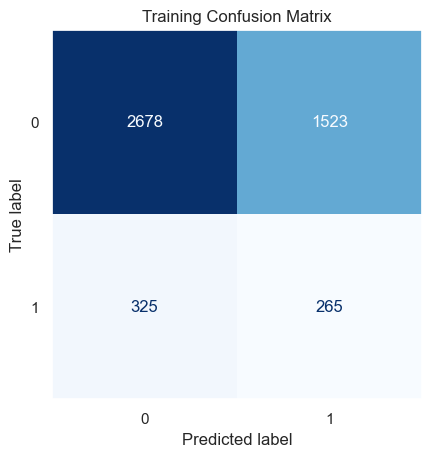

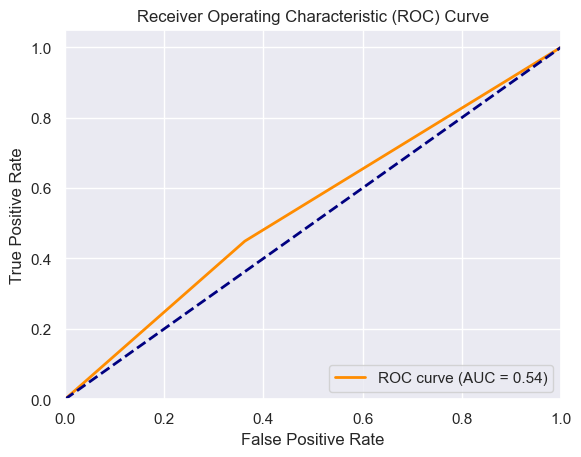

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Train,0.54331,0.449153,0.222876,0.134405,0.14821,0.637467,0.54331


In [43]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train, y_train, flag=False)

# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

In [44]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Candidate'
Model = 'rfc_can_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_can_fit = stratified_grid(model, parameters, X_train_can, y_train_can)

# best model
model = rfc_can_fit.best_estimator_

CV accuracy: 0.545 +/- 0.020


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.41      0.57      4201
           1       0.15      0.73      0.24       590

    accuracy                           0.45      4791
   macro avg       0.53      0.57      0.40      4791
weighted avg       0.82      0.45      0.53      4791



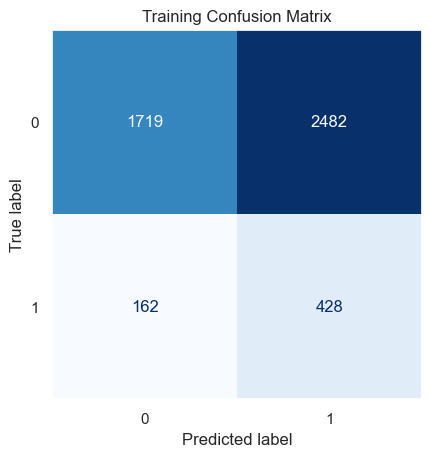

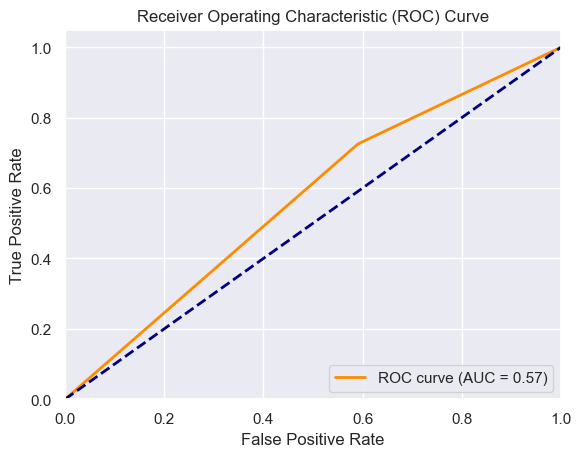

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Train,0.543310,0.449153,0.222876,0.134405,0.148210,0.637467,0.543310
1,RandomForestClassifier,rfc_can_fit,RandomForestClassifier - Grid Search - Candidate,Train,0.567306,0.725424,0.244571,0.140508,0.147079,0.409188,0.567306


In [45]:
# classfication metrics
df_classfication = metricsClassifier(model, X_train_can, y_train_can, df_classfication, flag='Train')

# display
df_classfication

In [46]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Donor'
Model = 'rfc_don_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_don_fit = stratified_grid(model, parameters, X_train_don, y_train_don)

# best model
model = rfc_don_fit.best_estimator_

CV accuracy: 0.512 +/- 0.018


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      4201
           1       0.00      0.00      0.00       590

    accuracy                           0.88      4791
   macro avg       0.44      0.50      0.47      4791
weighted avg       0.77      0.88      0.82      4791



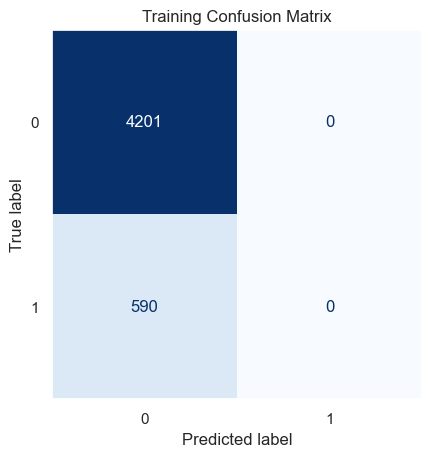

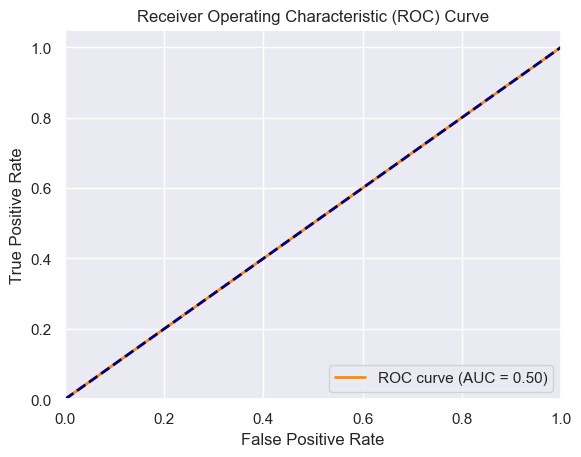

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Train,0.543310,0.449153,0.222876,0.134405,0.148210,0.637467,0.543310
1,RandomForestClassifier,rfc_can_fit,RandomForestClassifier - Grid Search - Candidate,Train,0.567306,0.725424,0.244571,0.140508,0.147079,0.409188,0.567306
2,RandomForestClassifier,rfc_don_fit,RandomForestClassifier - Grid Search - Donor,Train,0.500000,0.000000,0.000000,0.123148,0.000000,1.000000,0.500000


In [47]:
# classfication metrics
df_classfication = metricsClassifier(model, X_train_don, y_train_don, df_classfication, flag='Train')

# display
df_classfication

In [48]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - Grid Search - Both'
Model = 'rfc_both_fit'

# CV with grid search for Hyper-Parameter tuning
rfc_both_fit = stratified_grid(model, parameters, X_train_both, y_train_both)

# best model
model = rfc_both_fit.best_estimator_

CV accuracy: 0.503 +/- 0.005


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      4201
           1       0.00      0.00      0.00       590

    accuracy                           0.88      4791
   macro avg       0.44      0.50      0.47      4791
weighted avg       0.77      0.88      0.82      4791



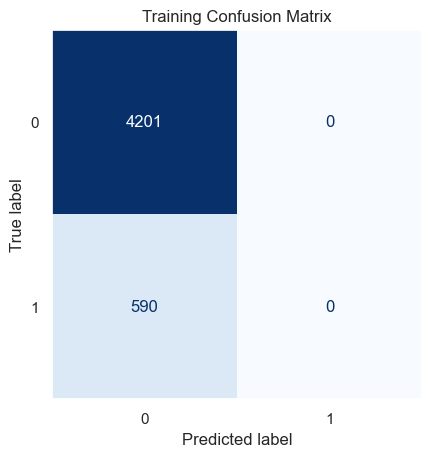

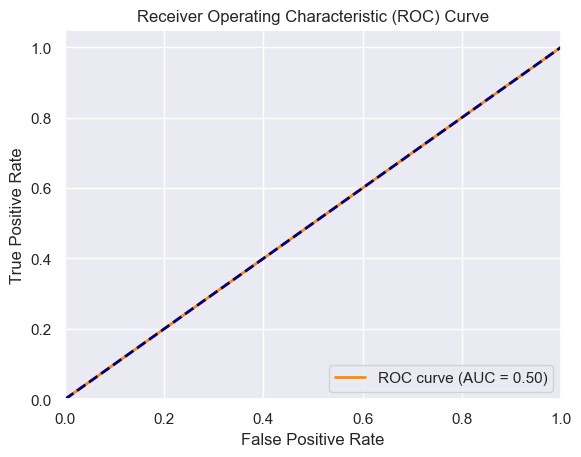

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,RandomForestClassifier,rfc_all_fit,RandomForestClassifier - Grid Search - Full,Train,0.543310,0.449153,0.222876,0.134405,0.148210,0.637467,0.543310
1,RandomForestClassifier,rfc_can_fit,RandomForestClassifier - Grid Search - Candidate,Train,0.567306,0.725424,0.244571,0.140508,0.147079,0.409188,0.567306
2,RandomForestClassifier,rfc_don_fit,RandomForestClassifier - Grid Search - Donor,Train,0.500000,0.000000,0.000000,0.123148,0.000000,1.000000,0.500000
3,RandomForestClassifier,rfc_both_fit,RandomForestClassifier - Grid Search - Both,Train,0.500000,0.000000,0.000000,0.123148,0.000000,1.000000,0.500000


In [49]:
# classfication metrics
df_classfication = metricsClassifier(model, X_train_both, y_train_both, df_classfication, flag='Train')

# display
df_classfication

#### Important Features

                                                                    % Feature Importance
CigaretteUse_CAN                                                               33.333333
AntigenDR51_2_CAN                                                              33.333333
AntigenDR53_2_CAN                                                              33.333333
Hypertension_DON_Y                                                              0.000000
Hypertension_DON_U                                                              0.000000
CigaretteHistory_DON_Y                                                          0.000000
CigaretteHistory_DON_U                                                          0.000000
ExtracanialCancer_DON_Y                                                         0.000000
ExtracanialCancer_DON_U                                                         0.000000
OtherDrugUse_DON_Y                                                              0.000000
OtherDrugUse_DON_U   

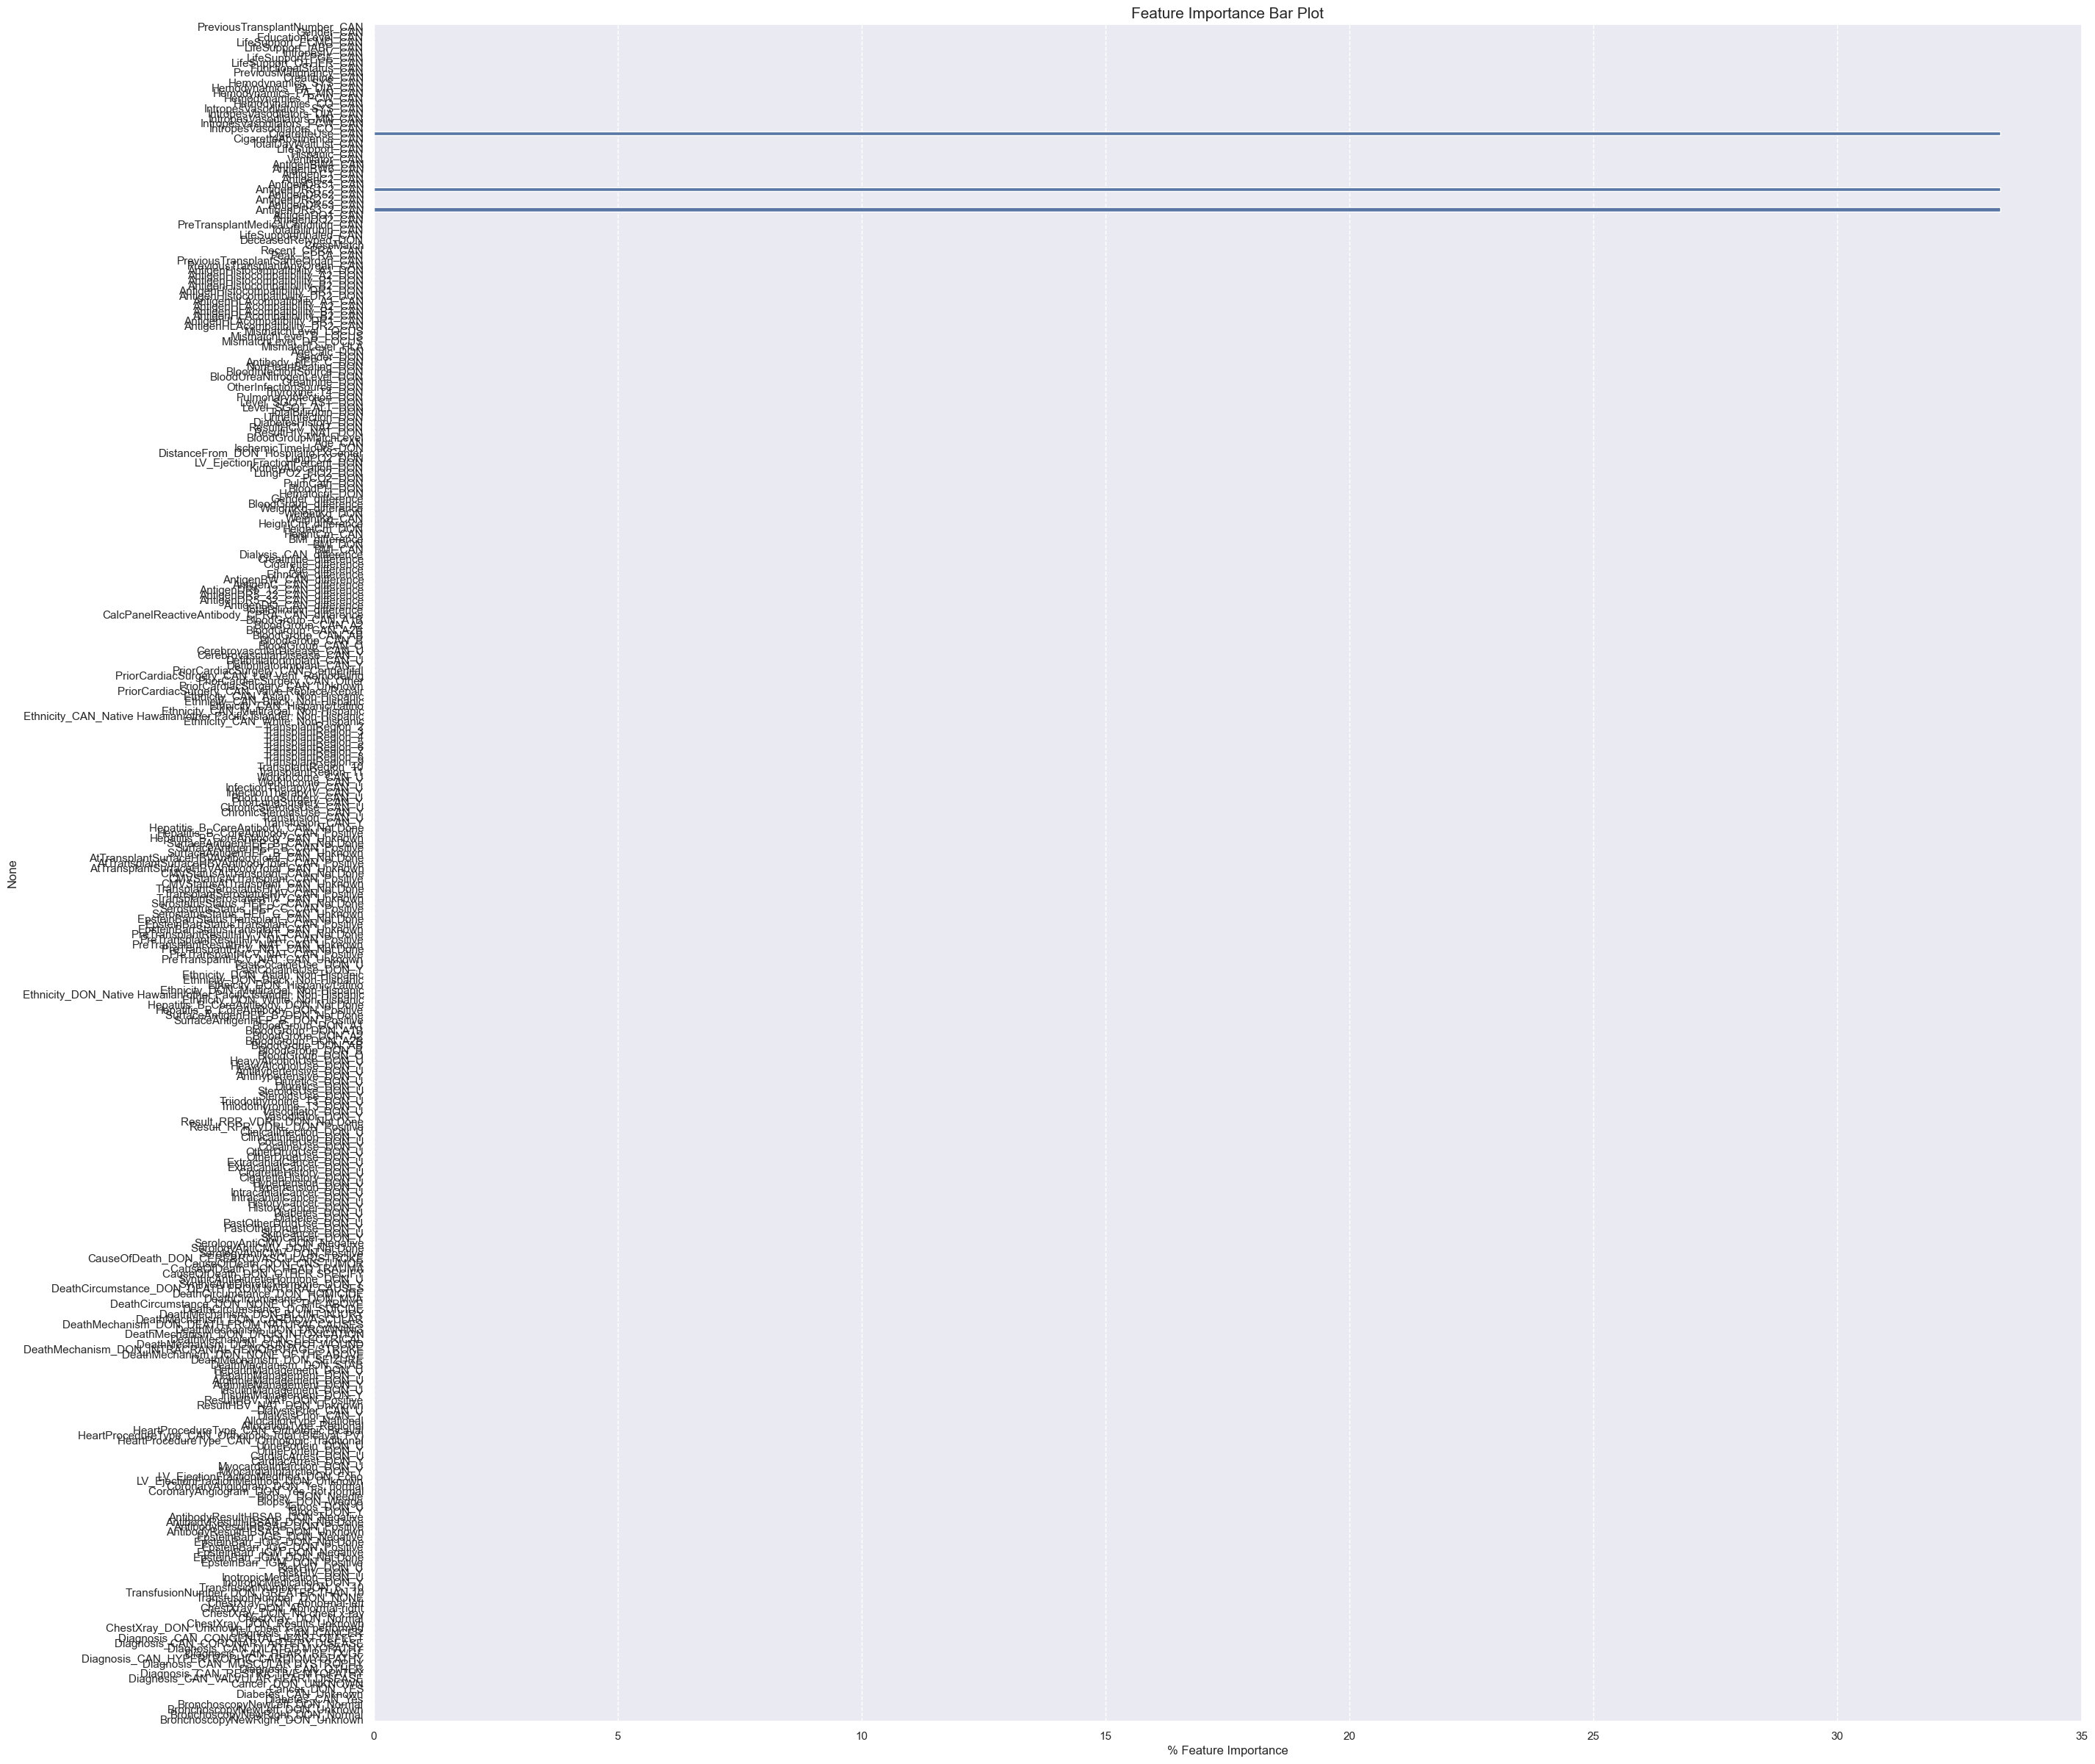

In [51]:
# candidate
model = rfc_all_fit.best_estimator_

# plot
plotFeatureImportance(model, X_train)

In [30]:
# do not encode TransplantStatus
catCol.remove('TransplantStatus_CAN')

# OneHotEncoding
df = pd.get_dummies(df, columns=catCol, drop_first=True)
df.head()

,PreviousTransplantNumber_CAN,Gender_CAN,EducationLevel_CAN,LifeSupport_ECMO_CAN,LifeSupport_IABP_CAN,IntropesIV_CAN,LifeSupport_PGE_CAN,LifeSupport_OTHER_CAN,FunctionalStatus_CAN,PreviousMalignancy_CAN,Creatinine_CAN,Hemodynamics_SYS_CAN,Hemodynamics_PA_DIA_CAN,Hemodynamics_PA_MN_CAN,Hemodynamics_PCW_CAN,Hemodynamics_CO_CAN,IntropesVasodilators_SYS_CAN,IntropesVasodilators_DIA_CAN,IntropesVasodilators_MN_CAN,IntropesVasodilators_PCW_CAN,IntropesVasodilators_CO_CAN,CigaretteUse_CAN,CigaretteAbstinence_CAN,TotalDayWaitList_CAN,LifeSupport_CAN,Hispanic_CAN,Ventilator_CAN,AntigenBW4_CAN,AntigenBW6_CAN,AntigenC1_CAN,AntigenC2_CAN,AntigenDR51_CAN,AntigenDR51_2_CAN,AntigenDR52_CAN,AntigenDR52_2_CAN,AntigenDR53_CAN,AntigenDR53_2_CAN,AntigenDQ1_CAN,AntigenDQ2_CAN,PreTransplantMedicalCondition_CAN,TotalBilirubin_CAN,TransplantStatus_CAN,LifeSupportInhaled_CAN,DeceasedRetyped_DON,CrossMatch,Recent_CPRA_CAN,Peak_CPRA_CAN,PreviousTransplantSameOrgan_CAN,PreviousTransplantAnyOrgan_CAN,AntigenHistocompatibility_A1_DON,AntigenHistocompatibility_A2_DON,AntigenHistocompatibility_B1_DON,AntigenHistocompatibility_B2_DON,AntigenHistocompatibility_DR1_DON,AntigenHistocompatibility_DR2_DON,AntigenHLAcompatibility_A1_CAN,AntigenHLAcompatibility_A2_CAN,AntigenHLAcompatibility_B1_CAN,AntigenHLAcompatibility_B2_CAN,AntigenHLAcompatibility_DR1_CAN,AntigenHLAcompatibility_DR2_CAN,MismatchLevel_LOCUS,MismatchLevel_B_LOCUS,MismatchLevel_DR_LOCUS,MismatchLevel_HLA,AgeCalc_DON,Gender_DON,Antibody_HEP_C_DON,NonHeartBeating_DON,BloodInfectionSource_DON,BloodUreaNitrogenLevel_DON,Creatinine_DON,OtherInfectionSource_DON,Thyroxine_T4_DON,PulmonaryInfection_DON,Level_SGOT_AST_DON,Level_SGOT_ALT_DON,TotalBilirubin_DON,UrineInfection_DON,DiabetesHistory_DON,ResultHCV_NAT_DON,ResultHIV_NAT_DON,BloodGroupMatchLevel,Age_CAN,IschemicTimeHours_DON,DistanceFrom_DON_HospitaltoTXCenter,LungPO2_DON,LV_EjectionFractionPercent_DON,KidneyAllocation_DON,LungPO2_FIO2_DON,PCO2_DON,PulmCath_DON,BloodPH_DON,Hematocrit_DON,Gender_difference,BloodGroup_difference,WeightKg_difference,WeightKg_DON,WeightKg_CAN,HeightCm_difference,HeightCm_DON,HeightCm_CAN,BMI_difference,BMI_DON,BMI_CAN,Dialysis_CAN_difference,Creatinine_difference,Cigarette_difference,Age_difference,Ethnicity_difference,AntigenBW_CAN_difference,AntigenC_CAN_difference,AntigenDR5_12_CAN_difference,AntigenDR5_22_CAN_difference,AntigenDR5_32_CAN_difference,AntigenDQ_CAN_difference,TotalBilirubin_difference,CalcPanelReactiveAntibody_CPRA_CAN_difference,BloodGroup_CAN_A1B,BloodGroup_CAN_A2,BloodGroup_CAN_A2B,BloodGroup_CAN_AB,BloodGroup_CAN_B,BloodGroup_CAN_O,CerebrovascularDisease_CAN_U,CerebrovascularDisease_CAN_Y,DefibrillatorImplant_CAN_U,DefibrillatorImplant_CAN_Y,PriorCardiacSurgery_CAN_Congenital,PriorCardiacSurgery_CAN_Left Vent. Remodeling,PriorCardiacSurgery_CAN_Other,PriorCardiacSurgery_CAN_Unknown,PriorCardiacSurgery_CAN_Valve Replace/Repair,"Ethnicity_CAN_Asian, Non-Hispanic","Ethnicity_CAN_Black, Non-Hispanic",Ethnicity_CAN_Hispanic/Latino,"Ethnicity_CAN_Multiracial, Non-Hispanic","Ethnicity_CAN_Native Hawaiian/other Pacific Islander, Non-Hispanic","Ethnicity_CAN_White, Non-Hispanic",TransplantRegion_2,TransplantRegion_3,TransplantRegion_4,TransplantRegion_5,TransplantRegion_6,TransplantRegion_7,TransplantRegion_8,TransplantRegion_9,TransplantRegion_10,TransplantRegion_11,WorkIncome_CAN_U,WorkIncome_CAN_Y,InfectionTherapyIV_CAN_U,InfectionTherapyIV_CAN_Y,PriorLungSurgery_CAN_U,PriorLungSurgery_CAN_Y,ChronicSteroidsUse_CAN_U,ChronicSteroidsUse_CAN_Y,Transfusion_CAN_U,Transfusion_CAN_Y,Hepatitis_B_CoreAntibody_CAN_Not Done,Hepatitis_B_CoreAntibody_CAN_Positive,Hepatitis_B_CoreAntibody_CAN_Unknown,SurfaceAntigenHEP_B_CAN_Not Done,SurfaceAntigenHEP_B_CAN_Positive,SurfaceAntigenHEP_B_CAN_Unknown,AtTransplantSurfaceHBVAntibodyTotal_CAN_Not Done,AtTransplantSurfaceHBVAntibodyTotal_CAN_Positive,AtTransplantSurfaceHBVAntibodyTotal_CAN_Unknown,CMVStatusAtTransplant_CAN_Not Done,CMVStatusAtTransplant_CAN_Positive,CMVStatu

In [31]:
df.shape

(8557, 336)

In [32]:
# split test and train
from sklearn.model_selection import train_test_split

# df DataFrame and
X = df.drop('TransplantStatus_CAN', axis=1)
y = df['TransplantStatus_CAN']

# split the dataset into 80% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y)

# split train data into validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

In [33]:
y_train.value_counts()

TransplantStatus_CAN
0    4201
1     590
Name: count, dtype: int64

In [34]:
y_val.value_counts()

TransplantStatus_CAN
0    1050
1     148
Name: count, dtype: int64

In [35]:
y_test.value_counts()

TransplantStatus_CAN
0    2251
1     317
Name: count, dtype: int64

In [36]:
# MinMax Scaling
scaler = MinMaxScaler()

# fit
MinMaxScale = scaler.fit(X_train)

# transform
X_train_scaled = MinMaxScale.transform(X_train)
X_val_scaled = MinMaxScale.transform(X_val)
X_test_scaled = MinMaxScale.transform(X_test)

# convert the scaled data back into a DataFrame with the original column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# change datatype for FAMD
X_train_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_val_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')
X_test_scaled_df[boolCol] = X_train_scaled_df[boolCol].astype('category')

In [37]:
X_train_scaled_df.shape

(4791, 335)

### Factor Analysis of Mixed Data (FAMD)

In [38]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [39]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_3 = prince.FAMD(n_components=335, n_iter=3, random_state=RANDOM_STATE).fit(X_train_scaled_df)
famd_5 = prince.FAMD(n_components=335, n_iter=5, random_state=RANDOM_STATE).fit(X_train_scaled_df)

# checking loading stability - get column contributions
famd_3_contributions = famd_3.column_contributions_
famd_5_contributions = famd_5.column_contributions_

# compare contributions between 3 iterations and 5 iterations
contribution_diff = famd_5_contributions - famd_3_contributions

In [40]:
# display
contribution_diff.head()

component,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334
variable,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
PreviousTransplantNumber_CAN,-8.056977e-18,-1.576837e-17,1.162265e-16,-4.065758e-19,-5.334275e-17,-8.741380e-19,2.263272e-17,-6.709798e-18,-1.105886e-17,3.876023e-18,3.984443e-18,-2.384398e-19,-8.280594e-18,4.196949e-20,4.531626e-19,-1.026604e-17,4.593460e-18,-8.652442e-19,1.892272e-18,-4.912791e-19,1.418780e-19,-3.979731e-20,-6.143106e-19,1.802063e-19,1.626303e-19,6.827086e-19,1.897354e-19,-3.252607e-19,-2.270048e-19,-6.420510e-19,-7.453890e-19,4.379160e-19,6.166400e-19,-2.498747e-18,2.801985e-18,-2.325436e-19,7.250602e-19,-9.774760e-19,-3.523657e-19,7.885877e-19,-3.303428e-18,1.992221e-18,2.998497e-19,2.076091e-19,4.336809e-19,-2.178992e-19,-6.572976e-19,1.051711e-19,5.376542e-19,6.488272e-19,6.118225e-19,-4.743385e-20,1.435086e-18,-4.458781e-18,2.378469e-18,-3.109034e-18,1.965116e-19,9.791701e-18,-4.296151e-18,2.376324e-20,-8.663453e-18,-3.489776e-18,-3.889575e-18,1.546682e-18,1.070650e-17,-4.820465e-18,9.215718e-18,-5.153348e-18,-5.514184e-19,-4.784042e-18,2.392021e-18,9.342773e-19,-6.723409e-17,7.010383e-17,-1.809262e-18,6.096943e-18,-1.942458e-18,1.076071e-17,-1.485357e-17,-1.011696e-17,1.528302e-17,-2.087089e-18,1.154506e-18,-5.209591e-17,4.220257e-17,-1.946143e-17,1.081492e-17,-3.981055e-18,1.352923e-18,-3.587354e-17,-1.603806e-16,2.213263e-16,-1.050321e-18,8.626184e-18,1.558270e-16,7.326496e-17,-8.549612e-17,-2.033963e-16,6.152847e-17,-3.123858e-18,2.612927e-17,2.167557e-18,-1.268935e-18,-2.328547e-19,-4.420157e-17,-3.239054e-18,-1.066203e-18,-1.049508e-16,8.014965e-17,9.649399e-18,-1.138412e-18,-5.851304e-18,-2.098270e-17,1.124318e-16,3.569194e-16,-4.567202e-16,4.878910e-17,-3.194161e-17,-4.336809e-19,-6.795237e-17,-5.080842e-17,1.227317e-16,-1.228401e-16,-1.389236e-16,2.756855e-16,-2.741676e-17,-1.331536e-17,-1.409463e-18,-4.370690e-18,5.032053e-17,-2.504507e-17,-2.817062e-17,2.752857e-18,-1.693947e-16,1.563691e-16,3.497399e-18,6.288373e-18,-1.846532e-18,-8.775261e-18,-2.803679e-18,-4.231777e-18,1.559896e-17,1.700842e-18,-4.136231e-17,6.471332e-17,-6.098637e-19,-2.802663e-17,1.124860e-18,2.280213e-18,-1.065771e-16,-6.471332e-18,4.941251e-17,-1.109952e-17,-4.724411e-17,3.859760e-17,3.333922e-17,-3.381356e-18,3.007983e-17,3.504684e-17,-1.093689e-17,2.272759e-17,1.360674e-17,9.840829e-18,-1.561251e-17,-4.415413e-17,-1.989511e-17,2.287667e-17,2.580401e-16,-4.310788e-16,5.919744e-17,3.292586e-17,7.050025e-17,-1.079120e-17,-5.668683e-17,1.984090e-16,-8.322946e-17,2.657

**Note:**
- The differences between the contributions are small (close to zero), the model has likely converged.

In [41]:
# transform the data
X_train_famd = famd_5.transform(X_train_scaled_df)

In [42]:
# create an FAMD object and fit it to the data (keep both categorical and numerical)
famd_val = prince.FAMD(n_components=374, n_iter=5, random_state=RANDOM_STATE).fit(X_val_scaled_df)
famd_test = prince.FAMD(n_components=374, n_iter=5, random_state=RANDOM_STATE).fit(X_test_scaled_df)

# transform
X_val_famd = famd_val.transform(X_val_scaled_df)
X_test_famd = famd_test.transform(X_test_scaled_df)

In [43]:
X_train_famd.shape, X_val_famd.shape, X_test_famd.shape

((4791, 335), (1198, 335), (2568, 335))

In [44]:
# select value less than 96%
cumVar = famd_5.cumulative_percentage_of_variance_[famd_5.cumulative_percentage_of_variance_ < 96]

# shape
cumVar.shape

(182,)

In [45]:
# select first 331 loadings
X_train_famd = X_train_famd.iloc[:, :182].copy()
X_val_famd = X_val_famd.iloc[:, :182].copy()
X_test_famd = X_test_famd.iloc[:, :182].copy()

# shape
X_train_famd.shape, X_val_famd.shape, X_test_famd.shape

((4791, 182), (1198, 182), (2568, 182))

### PCA

In [46]:
# initialize PCA object (n_components can be set based on variance explained or manually)
pca = PCA(n_components = 133) 

# fit the PCA model and transform the data
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.fit_transform(X_val_scaled)
X_test_pca = pca.fit_transform(X_test_scaled)

In [47]:
np.cumsum(pca.explained_variance_ratio_)

array([0.06548444, 0.1165749 , 0.15891887, 0.19340046, 0.22343851,
       0.25080423, 0.27566739, 0.29847024, 0.3196424 , 0.33999817,
       0.35973755, 0.3769575 , 0.39269899, 0.40789868, 0.42247359,
       0.43626155, 0.4497945 , 0.4630125 , 0.47556357, 0.48788434,
       0.49978989, 0.51100957, 0.52164788, 0.53194019, 0.54213081,
       0.55196985, 0.56158912, 0.57105308, 0.58019442, 0.58925428,
       0.59800055, 0.6064706 , 0.61482983, 0.62300459, 0.63072797,
       0.6383611 , 0.64596646, 0.65345982, 0.66069119, 0.66777023,
       0.67469716, 0.68154401, 0.68824373, 0.69477239, 0.70110409,
       0.70732473, 0.71336177, 0.71923018, 0.72490174, 0.73051068,
       0.73597748, 0.74130477, 0.74653853, 0.75154267, 0.75644282,
       0.76122872, 0.76600111, 0.77058179, 0.77512856, 0.77957991,
       0.78395163, 0.7882235 , 0.79240691, 0.79655972, 0.80061336,
       0.80458333, 0.80848911, 0.8123027 , 0.81610444, 0.81984596,
       0.82346588, 0.82705009, 0.83057032, 0.83406852, 0.83750

In [48]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((4791, 133), (1198, 133), (2568, 133))

### User Function(s)

- Mean Absolute Error (MAE)
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-squared (Coefficient of Determination)
- Mean Absolute Percentage Error (MAPE)

In [50]:
from imblearn.over_sampling import SMOTE

# initialize smote
smote = SMOTE(random_state=RANDOM_STATE)

X_resampled_pca, y_resampled_pca = smote.fit_resample(X_train_pca, y_train)
X_resampled_famd, y_resampled_famd = smote.fit_resample(X_train_famd, y_train)

### Machine Learning

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

### LinearDiscriminantAnalysis
- Parameters: Solver to use:
    - `svd`: Singular value decomposition (default). Does not compute the covariance matrix, therefore this solver is recommended for data with a large number of features.
    - `lsqr`: Least squares solution, can be combined with shrinkage.
    - `eigen`: Eigenvalue decomposition, can be combined with shrinkage.
- Parameters: Shrinkage parameter: (shrinkagestring or float, optional)
    - `None`: no shrinkage (default).
    - `auto`: automatic shrinkage using the Ledoit-Wolf lemma.
    - float between `0` and `1`: fixed shrinkage parameter.

**Note** that shrinkage works only with ‘lsqr’ and ‘eigen’ solvers.

#### FAMD

In [52]:
# initialize variables
Algorithm = 'LinearDiscriminantAnalysis'
Desc = 'LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%'
Model = 'lda_famd_fit'

# define the hyperparameter grid to search
parameters = {
                'solver': ['lsqr', 'eigen'],  # solver
                'shrinkage': [None, 'auto']
             }

# define default parameters 
default_param = {
    'solver':  'svd'
    }

# instantiate the LDA model
lda_famd = LinearDiscriminantAnalysis(**default_param)

# CV_GS
lda_famd_fit = stratified_grid(lda_famd, parameters, X_train_famd, y_train)

# best model
model = lda_famd_fit.best_estimator_

CV accuracy: 0.031 +/- 0.024


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.99      0.93      4201
           1       0.42      0.03      0.06       590

    accuracy                           0.88      4791
   macro avg       0.65      0.51      0.50      4791
weighted avg       0.82      0.88      0.83      4791



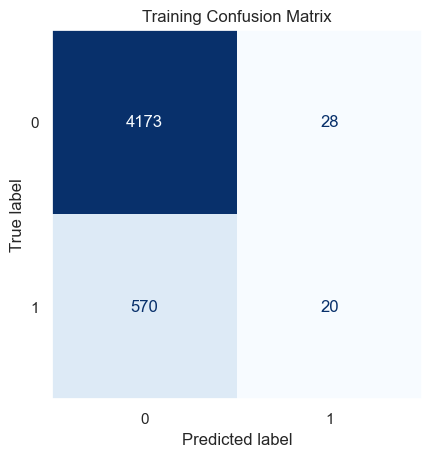

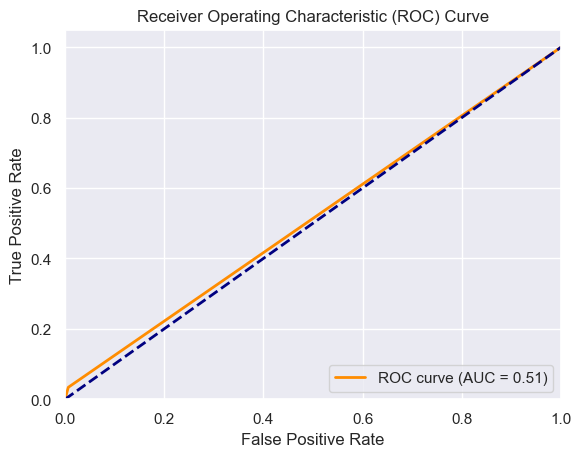

In [53]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_famd, y_train)

In [54]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# copy first metrics dataframe
df_classfication = df_metrics.copy()

# dispaly
df_classfication

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Train,0.513617,0.033898,0.062696,0.133097,0.416667,0.993335,0.513617


***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      1050
           1       0.00      0.00      0.00       148

    accuracy                           0.87      1198
   macro avg       0.44      0.50      0.47      1198
weighted avg       0.77      0.87      0.82      1198



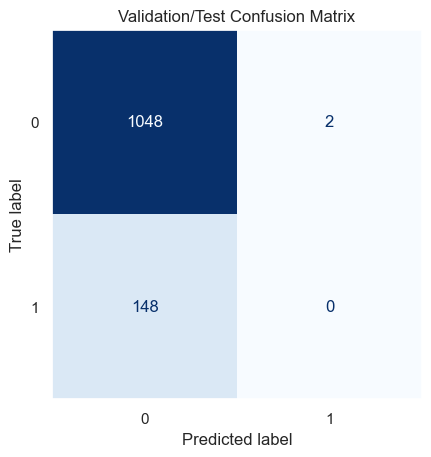

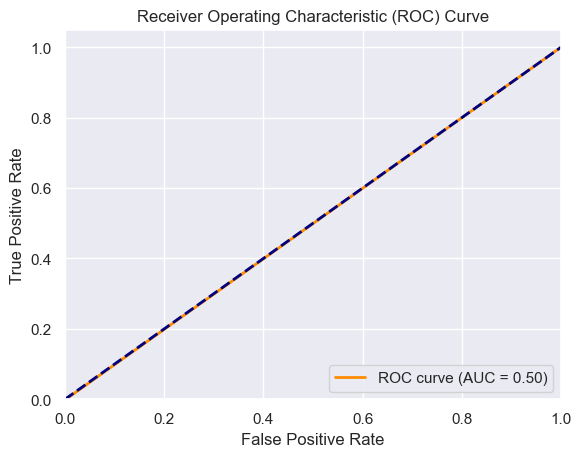

In [55]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_famd, y_val, True)

In [56]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Train,0.513617,0.033898,0.062696,0.133097,0.416667,0.993335,0.513617
1,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Validation,0.499048,0.000000,NaN,0.123539,0.000000,0.998095,0.499048


#### PCA

In [57]:
# initialize variables
Algorithm = 'LinearDiscriminantAnalysis'
Desc = 'LinearDiscriminantAnalysis - PCA Grid Search - 132 Feature @ 95%'
Model = 'lda_pca_fit'

# define the hyperparameter grid to search
parameters = {
                'solver': ['lsqr', 'eigen'],  # solver
                'shrinkage': [None, 'auto']
             }

# define default parameters 
default_param = {
    'solver':  'svd'
    }

# instantiate the LDA model
lda_famd = LinearDiscriminantAnalysis(**default_param)

# CV_GS
lda_pca_fit = stratified_grid(lda_famd, parameters, X_train_pca, y_train)

# best model
model = lda_pca_fit.best_estimator_

CV accuracy: 0.019 +/- 0.025


***** Classfication Metrics for Training:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      4201
           1       0.43      0.02      0.03       590

    accuracy                           0.88      4791
   macro avg       0.65      0.51      0.48      4791
weighted avg       0.82      0.88      0.82      4791



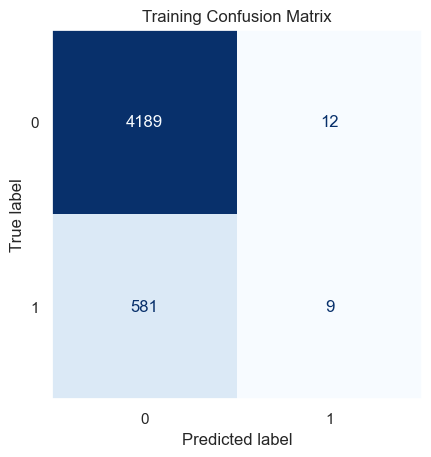

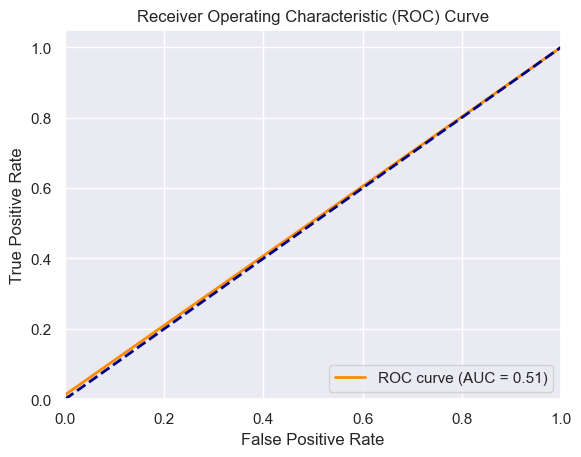

In [58]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_pca, y_train)

In [59]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Train,0.513617,0.033898,0.062696,0.133097,0.416667,0.993335,0.513617
1,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Validation,0.499048,0.000000,NaN,0.123539,0.000000,0.998095,0.499048
2,LinearDiscriminantAnalysis,lda_pca_fit,LinearDiscriminantAnalysis - PCA Grid Search - 132 Feature @ 95%,Train,0.506199,0.015254,0.029460,0.127807,0.428571,0.997144,0.506199


***** Classfication Metrics for Validation/Test:
Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.93      1050
           1       0.29      0.01      0.03       148

    accuracy                           0.87      1198
   macro avg       0.58      0.50      0.48      1198
weighted avg       0.80      0.87      0.82      1198



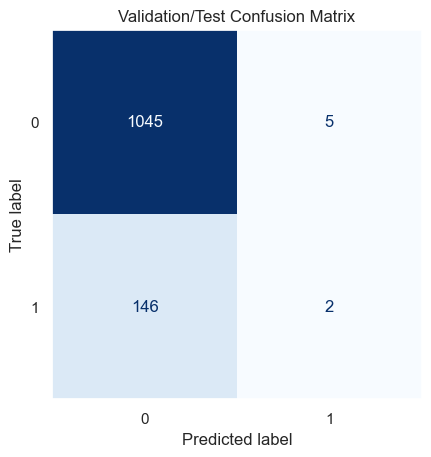

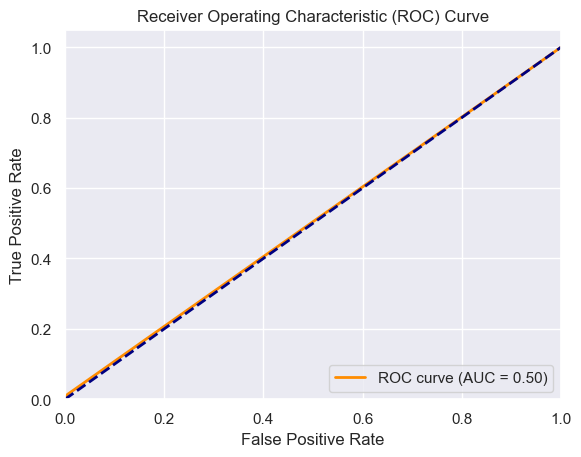

In [60]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_pca, y_val, True)

In [61]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

,Algorithm,Model,Description,DataType,BalancedAccuracy,RecallSensitivity,F1Score,AveragePrecision,Precision,Specificity,ROC_AUC_Score
0,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Train,0.513617,0.033898,0.062696,0.133097,0.416667,0.993335,0.513617
1,LinearDiscriminantAnalysis,lda_famd_fit,LinearDiscriminantAnalysis - FAMD Grid Search - 183 Feature @ 95%,Validation,0.499048,0.000000,NaN,0.123539,0.000000,0.998095,0.499048
2,LinearDiscriminantAnalysis,lda_pca_fit,LinearDiscriminantAnalysis - PCA Grid Search - 132 Feature @ 95%,Train,0.506199,0.015254,0.029460,0.127807,0.428571,0.997144,0.506199
3,LinearDiscriminantAnalysis,lda_pca_fit,LinearDiscriminantAnalysis - PCA Grid Search - 132 Feature @ 95%,Validation,0.504376,0.013514,0.025806,0.125731,0.285714,0.995238,0.504376


### Random Forest Classifier

In [ ]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - FAMD Grid Search - 332 Feature @ 95%'
Model = 'rfc_famd_fit'

# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 6, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(5,11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'], 
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_famd_fit = stratified_grid(model, parameters, X_train_famd, y_train)

# best model
model = rfc_famd_fit.best_estimator_

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_famd, y_train)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_famd, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### PCA
##### RandomForestClassifier

In [ ]:
# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - PCA Grid Search - 198 Feature @ 95%'
Model = 'rfc_pca_fit'

# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 6, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(5,11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'], 
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model 
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_pca_fit = stratified_grid(model, parameters, X_train_pca, y_train)

# best model
model = rfc_pca_fit.best_estimator_

In [ ]:
# display report - train
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_train_pca, y_train)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_pca, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

#### SMOTE (Over Sampling)
##### LinearDiscriminantAnalysis

In [ ]:
# initialize variables
Algorithm = 'LinearDiscriminantAnalysis'
Desc = 'LinearDiscriminantAnalysis - SMOTE - FAMD Grid Search - 332 Feature @ 95%'
Model = 'lda_famd_smote_fit'

# define the hyperparameter grid to search
parameters = {
                'solver': ['lsqr', 'eigen'],  # solver
                'shrinkage': [None, 'auto']
             }

# define default parameters 
default_param = {
    'solver':  'svd'
    }

# instantiate the LDA model
lda_famd = LinearDiscriminantAnalysis(**default_param)

# CV_GS
lda_famd_smote_fit = stratified_grid(lda_famd, parameters, X_resampled_famd, y_resampled_famd)

# best model
model = lda_famd_smote_fit.best_estimator_ 

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_resampled_famd, y_resampled_famd)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_famd, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# initialize variables
Algorithm = 'LinearDiscriminantAnalysis'
Desc = 'LinearDiscriminantAnalysis - SMOTE - FAMD Grid Search - 332 Feature @ 95%'
Model = 'lda_pca_smote_fit'

# define the hyperparameter grid to search
parameters = {
                'solver': ['lsqr', 'eigen'],  # solver
                'shrinkage': [None, 'auto']
             }

# define default parameters 
default_param = {
    'solver':  'svd'
    }

# instantiate the LDA model
lda_pca = LinearDiscriminantAnalysis(**default_param)

# CV_GS
lda_pca_smote_fit = stratified_grid(lda_pca, parameters, X_resampled_pca, y_resampled_pca)

# best model
model = lda_pca_smote_fit.best_estimator_ 

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_resampled_pca, y_resampled_pca)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_pca, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

##### Random Forest Classifier
###### FAMD

In [ ]:
# best# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - SMOTE - PCA Grid Search - 198 Feature @ 95%'
Model = 'rfc_famd_smote_fit'

# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 6, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(5,11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'], 
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_famd_smote_fit = stratified_grid(model, parameters, X_resampled_famd, y_resampled_famd)

# best model
model = rfc_famd_smote_fit.best_estimator_ 

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_resampled_famd, y_resampled_famd)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_famd, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

##### Random Forest Classifier
###### PCA

In [ ]:
# best# initialize variables
Algorithm = 'RandomForestClassifier'
Desc = 'RandomForestClassifier - SMOTE - PCA Grid Search - 198 Feature @ 95%'
Model = 'rfc_pca_smote_fit'

# minimum number of samples required to split a node
min_samples_split = list(np.linspace(2, 6, num=3, dtype=np.intc))

# maximum number of levels in tree
max_depth = list(np.linspace(5,11, num=3, dtype=np.intc))
max_depth.append(None)

# prunning parameters
ccp_alpha = list(np.around(np.linspace(0.01, 0.05, num=3), 3))

# define the hyperparameter grid to search
parameters = dict(
class_weight = [{0: 1, 1: 2}, {0: 1, 1: 4}, {0: 1, 1: 8}, 'balanced'], 
min_samples_split = min_samples_split,
max_depth = max_depth, 
ccp_alpha = ccp_alpha
)

# Base Model
rfc_param = {'random_state': RANDOM_STATE}

# instantiate RandomForest Classifier
model = RandomForestClassifier(**rfc_param)

# CV with grid search for Hyper-Parameter tuning
rfc_pca_smote_fit = stratified_grid(model, parameters, X_resampled_pca, y_resampled_pca)

# best model
model = rfc_pca_smote_fit.best_estimator_ 

In [ ]:
# display report - training
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_resampled_pca, y_resampled_pca)

In [ ]:
# initialize variable
Type = 'Train'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

# dispaly
df_classfication

In [ ]:
# display report - validation
Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC = classifier_metrics(model, X_val_pca, y_val, True)

In [ ]:
# initialize variable
Type = 'Validation'

# add to DataFrame
df_metrics = metricsClassfication(Algorithm, Model, Desc, Type, Specificity, RecallSensitivity, BalancedAccuracy, Precision, F1, AveragePrecision, AUC)

# concat two dataframes
df_classfication = pd.concat([df_classfication, df_metrics], ignore_index=True)

# reset the index
df_classfication.reset_index(drop=True, inplace=True)

In [ ]:
df_classfication